# TO DO
1. Посмотреть расстояние между 2 строками и минимизировать его
4. Найти pattern в путях? Где задерживалась цена во время пути во время рост или падения? 
   Вектор движения цены для создания кластеров.
5. Если диапазон широкий то какая с большей ли вероятностью что она развернется? количество точек разворота.

- были ли похоже последовательности раньше? 
- если цена сходила на -1, +1, можем ли мы думать, что она пойдет на -4 или около того?
- какой из диапазонов важен (в какой вторник месяца \ года) и как долго он остается важным? 
- остается ли уровень 0.5 (середина диапазона [0;1]) важным через 2 недели? можно ли это предсказать на основнии ширины изначального диапазона или движения цены?
- когда случаются ретесты диапазона [0;1] - через день? 5 дней? две недели?
- некоторые диапазоны дают последовательности +1 - (-3), то есть на одну гармонику вверх, потом на 3 вниз. можно ли это предсказать?
- поэтому мы смотрим на все повтояющиеся последовательности, а потом смотрим на предшействующие этим повтрояющимся события с ценой \ ширину диапазона
- также важно - гармоника - это линия, ограничивающая диапазон сверху \ снизу. то есть гармоника 0 - это низ нашего диапазона, 1 - верх, +2 - это линия ограничивающая один диапазон сверху

## UTC timzone

In [1]:
import requests
import joblib
import pandas as pd
from collections import defaultdict
from datetime import datetime
import pytz

# Create a datetime object in 'US/Eastern' timezone
eastern_timezone = pytz.timezone('US/Eastern')
eastern_datetime = eastern_timezone.localize(datetime(2022, 1, 1, 12, 0, 0))

# Convert to UTC
utc_datetime = eastern_datetime.astimezone(pytz.UTC)

print("Original datetime (US/Eastern):", eastern_datetime)
print("Converted datetime (UTC):", utc_datetime)

Original datetime (US/Eastern): 2022-01-01 12:00:00-05:00
Converted datetime (UTC): 2022-01-01 17:00:00+00:00


# Load Data

In [2]:
es_df = pd.read_csv('data/CME_MINI_DL_ES1!, 60 (1).csv')
es_df['time'] = pd.to_datetime(es_df['time'])
es_df = es_df.set_index('time')
es_df

,open,high,low,close
time,,,,
2020-01-09 13:00:00+00:00,3268.50,3271.75,3267.25,3270.75
2020-01-09 14:00:00+00:00,3270.75,3274.00,3265.50,3269.25
2020-01-09 15:00:00+00:00,3269.00,3274.75,3266.00,3274.00
2020-01-09 16:00:00+00:00,3274.00,3275.25,3270.00,3274.25
2020-01-09 17:00:00+00:00,3274.50,3275.25,3264.25,3269.50
...,...,...,...,...
2024-01-12 17:00:00+00:00,4807.00,4815.00,4803.50,4811.50
2024-01-12 18:00:00+00:00,4811.50,4820.50,4811.50,4819.50
2024-01-12 19:00:00+00:00,4819.75,4823.75,4811.50,4812.75


In [3]:
start_tuesday_cond = (
    ((es_df.index.weekday >= 1) & (es_df.index.hour >= 5))
    & ((es_df.index.weekday <= 2) & (es_df.index.hour <= 13))
)
es_df['is_diapazon_day'] = start_tuesday_cond
es_df['calendar_week'] = es_df.index.year.astype(str) + '-' + es_df.index.week.astype(str)

es_df['diapazan_week'] = es_df.loc[es_df['is_diapazon_day'], 'calendar_week']
es_df['diapazan_week'] = es_df['diapazan_week'].fillna(method='ffill')
es_df['diapazan_week'].count() - es_df['diapazan_week'].shape[0]

/tmp/ipykernel_13831/699407021.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  es_df['calendar_week'] = es_df.index.year.astype(str) + '-' + es_df.index.week.astype(str)


-61

In [4]:
window_size = (24 - 5) + 13
window_high = es_df[start_tuesday_cond].groupby('diapazan_week')['high'].max()
window_low = es_df[start_tuesday_cond].groupby('diapazan_week')['low'].min()
window_mid = (window_high + window_low) / 2
diapazon_ser = window_high - window_low
diapazon_ser

diapazan_week
2020-10     71.50
2020-11    114.75
2020-12    154.75
2020-13    219.75
2020-14    168.50
            ...  
2023-7      70.50
2023-8      77.50
2023-9      40.25
2024-1      62.50
2024-2      30.50
Length: 209, dtype: float64

In [5]:
es_df[(es_df['diapazan_week'] == '2021-1') & (es_df['is_diapazon_day'])]

,open,high,low,close,is_diapazon_day,calendar_week,diapazan_week
time,,,,,,,
2021-01-05 05:00:00+00:00,3690.75,3695.75,3688.50,3693.75,True,2021-1,2021-1
2021-01-05 06:00:00+00:00,3693.75,3701.00,3692.75,3700.25,True,2021-1,2021-1
2021-01-05 07:00:00+00:00,3700.50,3701.00,3677.75,3679.50,True,2021-1,2021-1
2021-01-05 08:00:00+00:00,3679.25,3703.50,3679.25,3696.75,True,2021-1,2021-1
2021-01-05 09:00:00+00:00,3696.50,3703.00,3693.75,3698.25,True,2021-1,2021-1
2021-01-05 10:00:00+00:00,3698.25,3701.75,3696.75,3698.25,True,2021-1,2021-1
2021-01-05 11:00:00+00:00,3698.50,3704.00,3691.25,3694.00,True,2021-1,2021-1
2021-01-05 12:00:00+00:00,3693.75,3695.50,3681.00,3689.75,True,2021-1,2021-1
2021-01-05 13:00:00+00:00,3689.50,3692.00,3674.00,3674.50,True,2021-1,2021-1


In [6]:
print('High:', window_high['2021-1'], 'Low:', window_low['2021-1'])

High: 3719.25 Low: 3674.0


In [7]:
es_df['mid_diapazon'] = es_df['diapazan_week'].map(window_mid)
mid_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='mid_diapazon', aggfunc='last'
)
mid_diapazon_table = mid_diapazon_table.fillna(method='ffill', axis=0)
mid_diapazon_table

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75
2024-01-12 18:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75
2024-01-12 19:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75


In [8]:
es_df['high_diapazon'] = es_df['diapazan_week'].map(window_high)
high_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='high_diapazon', aggfunc='last'
)
high_diapazon_table = high_diapazon_table.fillna(method='ffill', axis=0)
es_df['low_diapazon'] = es_df['diapazan_week'].map(window_low)
low_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='low_diapazon', aggfunc='last'
)
low_diapazon_table = low_diapazon_table.fillna(method='ffill', axis=0)
low_diapazon_table

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5
2024-01-12 18:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5
2024-01-12 19:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5


<Axes: title={'center': 'ES'}, xlabel='time'>

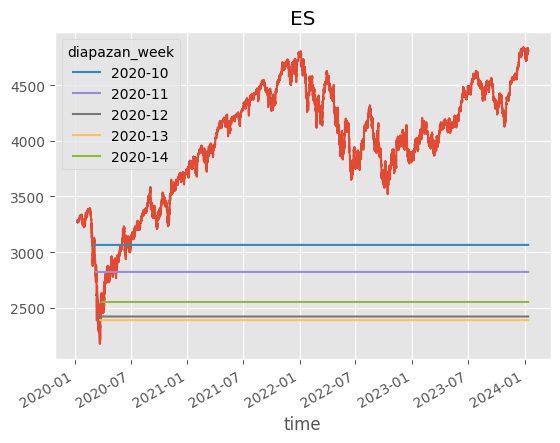

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ax = es_df['close'].plot()
mid_diapazon_table.iloc[:, :5].plot(ax=ax, title='ES')

In [10]:
harmonics = pd.DataFrame(index=mid_diapazon_table.columns, columns=list(range(-6, 7)))
n_harmonics = harmonics.shape[1]
for week in mid_diapazon_table.columns:
    for harmonic in harmonics.columns:
        harmonics.loc[week, harmonic] = -harmonic * diapazon_ser[week] + window_high[week]
harmonics = harmonics.astype(float)
harmonics

,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
diapazan_week,,,,,,,,,,,,,
2020-10,3529.00,3457.50,3386.00,3314.50,3243.00,3171.50,3100.00,3028.50,2957.00,2885.50,2814.00,2742.50,2671.00
2020-11,3567.50,3452.75,3338.00,3223.25,3108.50,2993.75,2879.00,2764.25,2649.50,2534.75,2420.00,2305.25,2190.50
2020-12,3426.50,3271.75,3117.00,2962.25,2807.50,2652.75,2498.00,2343.25,2188.50,2033.75,1879.00,1724.25,1569.50
2020-13,3816.50,3596.75,3377.00,3157.25,2937.50,2717.75,2498.00,2278.25,2058.50,1838.75,1619.00,1399.25,1179.50
2020-14,3646.75,3478.25,3309.75,3141.25,2972.75,2804.25,2635.75,2467.25,2298.75,2130.25,1961.75,1793.25,1624.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,4609.50,4539.00,4468.50,4398.00,4327.50,4257.00,4186.50,4116.00,4045.50,3975.00,3904.50,3834.00,3763.50
2023-8,4538.00,4460.50,4383.00,4305.50,4228.00,4150.50,4073.00,3995.50,3918.00,3840.50,3763.00,3685.50,3608.00
2023-9,4245.25,4205.00,4164.75,4124.50,4084.25,4044.00,4003.75,3963.50,3923.25,3883.00,3842.75,3802.50,3762.25


In [11]:
harmonics.iloc[0]

-6    3529.0
-5    3457.5
-4    3386.0
-3    3314.5
-2    3243.0
-1    3171.5
 0    3100.0
 1    3028.5
 2    2957.0
 3    2885.5
 4    2814.0
 5    2742.5
 6    2671.0
Name: 2020-10, dtype: float64

In [12]:
es_df = es_df.dropna()
es_df

,open,high,low,close,is_diapazon_day,calendar_week,diapazan_week,mid_diapazon,high_diapazon,low_diapazon
time,,,,,,,,,,
2020-01-14 05:00:00+00:00,3289.25,3290.75,3287.50,3288.25,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 06:00:00+00:00,3288.25,3290.25,3287.75,3289.75,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 07:00:00+00:00,3289.75,3290.50,3285.25,3285.50,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 08:00:00+00:00,3285.50,3286.00,3275.25,3283.00,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 09:00:00+00:00,3283.00,3292.50,3282.00,3291.00,True,2020-3,2020-3,3283.875,3292.5,3275.25
...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,4807.00,4815.00,4803.50,4811.50,False,2024-2,2024-2,4788.750,4804.0,4773.50
2024-01-12 18:00:00+00:00,4811.50,4820.50,4811.50,4819.50,False,2024-2,2024-2,4788.750,4804.0,4773.50
2024-01-12 19:00:00+00:00,4819.75,4823.75,4811.50,4812.75,False,2024-2,2024-2,4788.750,4804.0,4773.50


# Add week number

In [13]:
week_number_within_month = (
    (es_df.index.tz_localize(None) - pd.to_datetime(es_df.index.to_period("M").start_time)).days // 7) + 1

es_df['calendar_week_number_within_month'] = week_number_within_month
es_df['calendar_week_number_within_month'].value_counts()

/tmp/ipykernel_13831/1261846340.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  (es_df.index.tz_localize(None) - pd.to_datetime(es_df.index.to_period("M").start_time)).days // 7) + 1
/tmp/ipykernel_13831/1261846340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df['calendar_week_number_within_month'] = week_number_within_month


2    5515
3    5459
1    5401
4    5393
5    1895
Name: calendar_week_number_within_month, dtype: int64

In [14]:
# BECAUSE first element in list usually is first met by algorithm
diapazan_week2week_month = (
    es_df.groupby(['diapazan_week'])['calendar_week_number_within_month'].unique().str[0]
)
es_df['diapazan_week_number_within_month'] = es_df['diapazan_week'].map(diapazan_week2week_month)
es_df['diapazan_week_number_within_month']

/tmp/ipykernel_13831/3675042651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df['diapazan_week_number_within_month'] = es_df['diapazan_week'].map(diapazan_week2week_month)


time
2020-01-14 05:00:00+00:00    2
2020-01-14 06:00:00+00:00    2
2020-01-14 07:00:00+00:00    2
2020-01-14 08:00:00+00:00    2
2020-01-14 09:00:00+00:00    2
                            ..
2024-01-12 17:00:00+00:00    2
2024-01-12 18:00:00+00:00    2
2024-01-12 19:00:00+00:00    2
2024-01-12 20:00:00+00:00    2
2024-01-12 21:00:00+00:00    2
Name: diapazan_week_number_within_month, Length: 23663, dtype: int64

In [15]:
diapazan_week2weeknumber = es_df.drop_duplicates(subset=[
    'diapazan_week', 'diapazan_week_number_within_month'
]).set_index('diapazan_week')['diapazan_week_number_within_month']
diapazan_week2weeknumber.dropna().shape, len(diapazan_week2weeknumber.to_dict())

((209,), 209)

# Examine Future picrs


In [16]:
def get_harmonics_range(search_price: float, 
                        diapozan_week: 'str'):
    
    sorted_series = harmonics.loc[diapozan_week].sort_values().copy()
#     if previous_price >= search_price:
#         sorted_series = sorted_series * (1 + margin_of_error)
#     else:
#         sorted_series = sorted_series * (1 - margin_of_error)
    index = sorted_series.searchsorted(search_price)
    
    # Get the minimum and maximum thresholds
    min_threshold = index-1
    max_threshold = index
    harmonics_range = sorted_series.iloc[min_threshold: max_threshold+1].index
    if not harmonics_range.empty:
        return harmonics_range[0] - 1
    return harmonics.columns.max()

In [17]:
week_number2diapazonweek = defaultdict(list)
search_df = es_df[['diapazan_week_number_within_month', 'diapazan_week']].drop_duplicates()
week_numbers = es_df['diapazan_week_number_within_month'].unique().tolist()

for week_number in week_numbers:
    weeks = (
        search_df.loc[search_df['diapazan_week_number_within_month'] == week_number, 'diapazan_week']
    )
    week_number2diapazonweek[week_number] = weeks.values.tolist()
len(week_number2diapazonweek)

5

In [18]:
def get_week2paths(window: int, past_shift: int):
    """
        In: window - int - number of weeks forward to look forward
            past_shift - int - on how many "granularity" to shift prices from the past
                               to get direction of prices
        Out: at which diapazon look
    """
    
    week2path2count  = {week_number: {} for week_number in week_numbers}
    diapazons_week = harmonics.index

    for week_number, diapazons_weeks in week_number2diapazonweek.items():
        for diapozon_week in diapazons_weeks:
            path = []
            harmonic_levels = harmonics.loc[diapozon_week]

            start_date = es_df[
                (es_df['diapazan_week'] == diapozon_week) & (~es_df['is_diapazon_day'])
            ].index.min()
            end_date = start_date + pd.Timedelta(window, unit='w')

            future_prices = es_df.loc[start_date: end_date, 'close']
            past_prices = future_prices.shift(past_shift)
            for curr_price in future_prices:
                harmonic_number = get_harmonics_range(curr_price, diapozon_week)
                path.append(harmonic_number)
            week2path2count[week_number][diapozon_week] = path
    return week2path2count

In [19]:
%%time
week2path2count = get_week2paths(12, past_shift=3)
len(week2path2count)

CPU times: user 37.5 s, sys: 142 ms, total: 37.6 s
Wall time: 37.5 s


5

In [20]:
path2count = pd.Series(week2path2count[2])
path2count.head()

2020-3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2020-7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2020-11    [0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2020-16    [0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0...
2020-20    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
dtype: object

In [21]:
path2count.str.len()

2020-3     1374
2020-7     1355
2020-11    1354
2020-16    1373
2020-20    1373
2020-24    1377
2020-29    1377
2020-33    1376
2020-37    1373
2020-42    1324
2020-46    1321
2020-50    1324
2021-2     1367
2021-6     1371
2021-10    1371
2021-15    1373
2021-19    1373
2021-23    1377
2021-28    1377
2021-32    1377
2021-37    1373
2021-41    1350
2021-45    1347
2021-50    1350
2022-2     1374
2022-6     1355
2022-10    1355
2022-15    1346
2022-19    1369
2022-24    1369
2022-28    1377
2022-32    1377
2022-37    1373
2022-41    1327
2022-45    1324
2022-50    1327
2023-2     1374
2023-7     1371
2023-11    1370
2023-15    1370
2023-19    1366
2023-24    1366
2023-28    1377
2023-32    1377
2023-37    1373
2023-41    1327
2023-46     944
2023-50     491
2024-2       77
dtype: int64

In [22]:
import numpy as np 
pathes_df = (
    path2count.apply(pd.Series)
        .replace('', np.nan)
        .dropna(how='all', axis=1)
        .astype(float)
#         .dropna(axis=)
)
pathes_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376
2020-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN
2020-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-16,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,-4.0,-4.0,-4.0,-4.0,-5.0,-5.0,NaN,NaN,NaN,NaN
2020-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,NaN,NaN,NaN,NaN


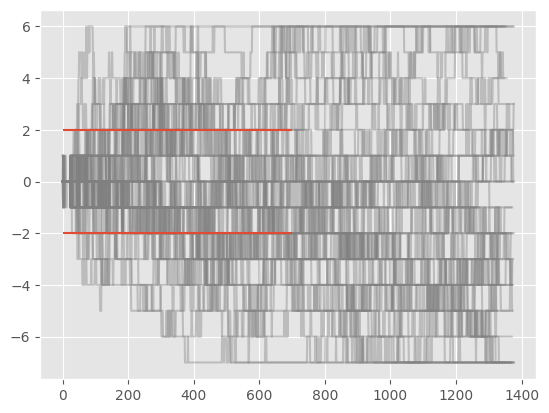

In [23]:
for idx in range(pathes_df.shape[0]):
    pathes_df.T.iloc[:, idx].plot(alpha=0.4, color='grey')
plt.hlines(2, 0, 700)
plt.hlines(-2, 0, 700)

In [24]:
harmonic2freq = {}
for harmonic in range(0, 7):
    is_in_middles = (pathes_df <= harmonic) & (pathes_df >= -harmonic)
    freq = is_in_middles.sum().sum() / pathes_df.count().sum()
    harmonic2freq[harmonic] = freq
harmonic2freq = pd.Series(harmonic2freq)
harmonic2freq

0    0.164518
1    0.393607
2    0.570220
3    0.706217
4    0.796892
5    0.865733
6    0.948880
dtype: float64

# Percentage in each harmonic for each week

In [25]:
def get_total_weeks_pathes(week2path2count):
    total_pathes_df = pd.DataFrame()
    for week, path2count_dict in week2path2count.items():
        path2count_week = pd.Series(path2count_dict)
        pathes_df_week = (
            path2count_week.apply(pd.Series)
                .replace('', np.nan)
                .dropna(how='all', axis=1)
                .astype(float)
        )
        total_pathes_df = pd.concat([pathes_df_week, total_pathes_df], axis=0)
    total_pathes_df = total_pathes_df.sort_index()
    return total_pathes_df
total_pathes_df = get_total_weeks_pathes(week2path2count)
print(total_pathes_df.shape)
display(total_pathes_df)

(209, 1378)


,0,1,2,3,4,5,6,7,8,9,...,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377
2020-10,0.0,-1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN
2023-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,NaN,NaN,NaN
2024-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


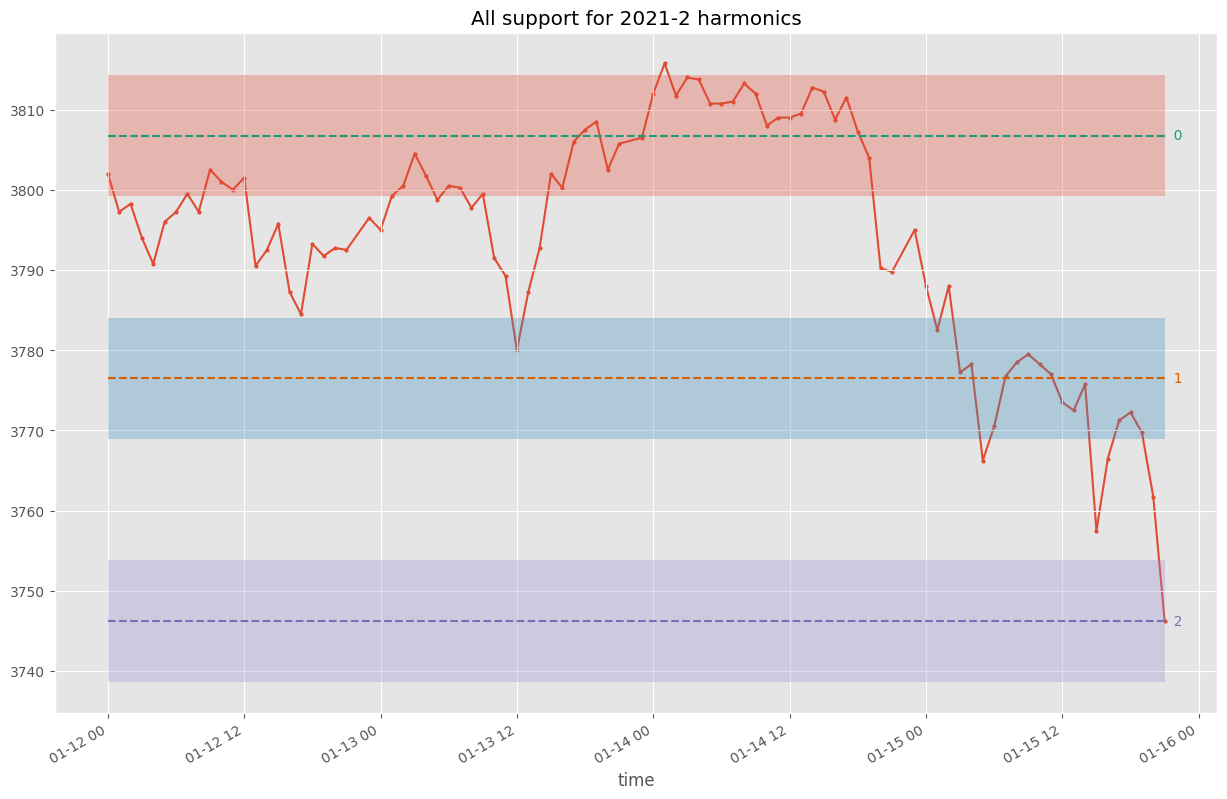

In [26]:
from matplotlib import colormaps

def plot_harmonics(diapazon_week, min_date, max_date, min_harmonic=-6, percentage_threshold: float = 0.25):
    plt.figure(figsize=(15, 10), )
    prices = es_df.loc[min_date: max_date, 'close']
    prices.plot(zorder=0, marker='o', markersize=2,
                title=f'All support for {diapazon_week} harmonics')
    unique_met_hormonics = [
        x for x in total_pathes_df.loc[diapazon_week].dropna().unique() 
        if x > min_harmonic
    ]
    harmonic_window = diapazon_ser[diapazon_week]
    colormap = colormaps['Dark2'] 
    # Generate a list of unique colors from the colormap
    colors = [colormap(i) for i in np.linspace(0, 1, harmonics.shape[1])]

    for idx, level in enumerate(unique_met_hormonics):
        harmonic_level_week = harmonics.loc[diapazon_week, level]
        
        upper_bound = harmonic_level_week + harmonic_window * percentage_threshold
        if (upper_bound > prices.max() or upper_bound < prices.min()):
            continue
        lower_bound = harmonic_level_week - harmonic_window * percentage_threshold
        max_x = prices.loc[min_date: max_date].index[-1]
        plt.hlines(harmonic_level_week, min_date, max_x, color=colors[idx], linestyle='--')
        plt.fill_between(prices.loc[min_date: max_date].index, lower_bound, upper_bound, alpha=0.3)

        plt.text(max_x, harmonic_level_week, f'  {level:.0f}', color=colors[idx],
                 verticalalignment='center', horizontalalignment='left')
    plt.show()
    
    
diapazon_week = '2021-2'
min_date = '2021-01-12'
max_date = '2021-01-15'
plot_harmonics(diapazon_week, min_date, max_date)

In [27]:
week_number_pathes_df = total_pathes_df.index.map(diapazan_week2weeknumber)

week_number2frac = pd.DataFrame()
for week, group in total_pathes_df.groupby(week_number_pathes_df):
    fracs = pd.DataFrame()
    for idx, row in group.iterrows():
        perc_counts = row.value_counts(normalize=False)
        fracs = pd.concat([perc_counts.to_frame(), fracs], axis=1).fillna(0)
    fracs = fracs.sum(axis=1)
    fracs.name = week
    
    week_number2frac = pd.concat([week_number2frac, fracs], axis=1)
week_number2frac

,1,2,3,4,5
0.0,7673.0,10556.0,7694.0,7351.0,2139.0
1.0,4910.0,5231.0,5839.0,4182.0,1853.0
-1.0,8876.0,9468.0,8781.0,7804.0,2208.0
2.0,3291.0,3939.0,3633.0,2741.0,1227.0
3.0,3456.0,2711.0,2540.0,1971.0,1030.0
4.0,2140.0,1524.0,1634.0,1605.0,706.0
-5.0,4221.0,3194.0,3464.0,4380.0,1425.0
-6.0,2750.0,1685.0,2406.0,2468.0,1170.0
-4.0,4137.0,4294.0,4383.0,5286.0,1527.0
-3.0,5298.0,6015.0,5901.0,7380.0,1589.0


In [28]:
def make_pretty(styler, vmin, vmax):
    styler.format("{:.3f}")
    styler.background_gradient(axis=None, vmin=vmin, vmax=vmax, cmap="YlGnBu")
    return styler
week_number2frac = week_number2frac / week_number2frac.sum(axis=0).values[None, :]
week_number2frac.style.pipe(make_pretty, 0, .3)

,1,2,3,4,5
0.000000,0.121,0.165,0.120,0.116,0.099
1.000000,0.078,0.082,0.091,0.066,0.086
-1.000000,0.140,0.148,0.137,0.123,0.102
2.000000,0.052,0.061,0.057,0.043,0.057
3.000000,0.055,0.042,0.040,0.031,0.048
4.000000,0.034,0.024,0.026,0.025,0.033
-5.000000,0.067,0.050,0.054,0.069,0.066
-6.000000,0.044,0.026,0.038,0.039,0.054
-4.000000,0.065,0.067,0.069,0.083,0.071
-3.000000,0.084,0.094,0.092,0.116,0.073


In [29]:
from sklearn.preprocessing import StandardScaler, Normalizer
scaler = StandardScaler()
z_scores_frac = scaler.fit_transform(week_number2frac)
z_scores_frac = pd.DataFrame(z_scores_frac, index=week_number2frac.index, columns=week_number2frac.columns)
z_scores_frac.style.pipe(make_pretty, -2, 2)

,1,2,3,4,5
0.000000,1.532,2.156,1.371,1.202,0.926
1.000000,0.192,0.234,0.559,-0.156,0.480
-1.000000,2.115,1.763,1.846,1.396,1.033
2.000000,-0.594,-0.232,-0.407,-0.774,-0.497
3.000000,-0.514,-0.676,-0.885,-1.104,-0.804
4.000000,-1.152,-1.104,-1.281,-1.261,-1.309
-5.000000,-0.143,-0.501,-0.481,-0.071,-0.188
-6.000000,-0.856,-1.046,-0.944,-0.891,-0.585
-4.000000,-0.183,-0.104,-0.078,0.317,-0.029
-3.000000,0.380,0.517,0.586,1.215,0.068


In [30]:
diffs = week_number2frac - week_number2frac.mean(axis=1).values[:, None]
diffs.style.pipe(make_pretty, -0.05, 0.05)

,1,2,3,4,5
0.000000,-0.003,0.040,-0.004,-0.009,-0.025
1.000000,-0.003,0.001,0.011,-0.015,0.005
-1.000000,0.010,0.018,0.007,-0.007,-0.028
2.000000,-0.002,0.007,0.003,-0.011,0.003
3.000000,0.012,-0.001,-0.003,-0.012,0.005
4.000000,0.006,-0.004,-0.003,-0.003,0.004
-5.000000,0.006,-0.011,-0.007,0.008,0.005
-6.000000,0.003,-0.014,-0.002,-0.001,0.014
-4.000000,-0.005,-0.004,-0.002,0.012,-0.000
-3.000000,-0.008,0.002,0.001,0.024,-0.018


## 80% of all movement happens inside -2:+2 harmonics range

# Find Probability of getting maxes

In [31]:
min_start = -2
max_end = -6
gap_days_index = 3

row_increasing_patterns = []
for idx, row in pathes_df.iterrows():
    
    # FILTER OUT ROWS WITHOUT NEEDED VALUES
    if min_start < max_end:

        row = row[(row >= min_start) & (row <= max_end)]
    else:
        row = row[(row <= min_start) & (row >= max_end)]
    
    
    if (not row.empty) and (max_end in row.values):
        
        # DISJOIN ROWS BY TIME
        index = pd.Series(row.index)
        start_indices = index[index > (index.shift(1) + gap_days_index)].values
        index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

        for idx, start_index in enumerate(start_indices):
            if idx == len(start_indices) -1:
                part_row = row[index_of_start_indices[idx]:]
            else:
                part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
            
            # FILTER OUT ONLY INCREASING PATERNS
            if max_end in part_row.values:
                break
                prev_harmonic = None
                start_index = 0
                part_row = part_row.values
                min_harmonic = part_row[0]

                for idx, harmonic_level in enumerate(part_row):
                    if harmonic_level == max_end and prev_harmonic != max_end:
                        increasing_harmonic = row_increasing[start_index: idx+1]
                        if len(increasing_harmonic) > 1 and part_row[start_index] != harmonic_level:
                            row_increasing_patterns.append(increasing_harmonic)
                        start_index = idx+1
                        min_harmonic = part_row[start_index]

                    if harmonic_level < min_harmonic:
                        min_harmonic = harmonic_level
                        start_index = idx + 1
                    prev_harmonic = harmonic_level
            
part_row = part_row.values
row_increasing_patterns = pd.DataFrame(row_increasing_patterns)
row_increasing_patterns

/tmp/ipykernel_13831/510850676.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:]
/tmp/ipykernel_13831/510850676.py:27: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]


""


In [32]:
prev_harmonic = None
increasing_harmonics = []
start_index = 0
display(part_row)
min_harmonic = part_row[0]
for idx, harmonic_level in enumerate(part_row):
    if harmonic_level == max_end and prev_harmonic != max_end:
        increasing_harmonic = part_row[start_index: idx+1]
        print(increasing_harmonic)
        if len(increasing_harmonic) > 1 and part_row[start_index] == min_start:
            increasing_harmonics.append(increasing_harmonic)
        start_index = idx+1
        if start_index < len(part_row)-1:
            min_harmonic = part_row[start_index]
    
    # find the smallest harmonic start
    if min_start < max_end:
        if harmonic_level < min_harmonic:
            min_harmonic = harmonic_level
            start_index = idx + 1
    else:
        if harmonic_level > min_harmonic:
            min_harmonic = harmonic_level
            start_index = idx + 1
    prev_harmonic = harmonic_level
    
for row_plot in increasing_harmonics:
    pd.Series(row_plot).plot()

array([-6., -6.])

[-6.]


In [33]:
all_higher_than_treshold_patterns = []
for idx, row in pathes_df.iterrows():
    if min_start < max_end:
        row = row[(row >= min_start)]#.tolist()
    else:
        row = row[(row <= min_start)]#.tolist()

    if not row.empty:
        index = pd.Series(row.index)
        start_indices = index[index > (index.shift(1) + gap_days_index)].values
        index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

        for idx, start_index in enumerate(start_indices):
            if idx == len(start_indices) -1:
                part_row = row[index_of_start_indices[idx]:].values
            else:
                part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values

            prev_harmonic = None
            start_index = 0
            min_harmonic = part_row[0]
            len_row = len(part_row)

            for idx, harmonic_level in enumerate(part_row):
                if (harmonic_level == min_start and prev_harmonic != min_start) or idx == len_row-1:
                    harmonics_oscilating = part_row[start_index: idx+1]
                    
                    if len(harmonics_oscilating) > 1 and part_row[start_index] == min_start:
                        all_higher_than_treshold_patterns.append(harmonics_oscilating)
                    start_index = idx+1
                prev_harmonic = harmonic_level
# for row_plot in increasing_harmonics:
#     pd.Series(row_plot).plot()
    
all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)
all_higher_than_treshold_patterns

/tmp/ipykernel_13831/2877829524.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:].values
/tmp/ipykernel_13831/2877829524.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values


,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,1000,1001,1002,1003
0,-2.0,-2.0,-3.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.0,-2.0,-2.0,-2.0,-3.0,-2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.0,-3.0,-3.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

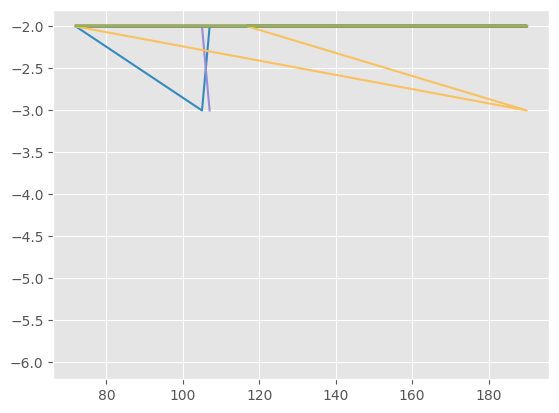

In [34]:
all_higher_than_treshold_patterns.sample(5, axis=0).plot(legend=None)
# plt.legend(False)

In [35]:
def get_increasing_patterns(df, min_start, max_end, gap_days_index: int = 3):
    # VERSION 3
    row_increasing_patterns = []
    for idx, row in df.iterrows():
    
        # FILTER OUT ROWS WITHOUT NEEDED VALUES
        if min_start < max_end:

            row = row[(row >= min_start) & (row <= max_end)]
        else:
            row = row[(row <= min_start) & (row >= max_end)]


        if (not row.empty) and (max_end in row.values):

            # DISJOIN ROWS BY TIME
            index = pd.Series(row.index)
            start_indices = index[index > (index.shift(1) + gap_days_index)].values
            index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

            for idx, start_index in enumerate(start_indices):
                if idx == len(start_indices) -1:
                    part_row = row[index_of_start_indices[idx]:]
                else:
                    part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]

                # FILTER OUT ONLY INCREASING PATERNS
                if max_end in part_row.values and len(part_row) > 1:
                    prev_harmonic = None
                    start_index = 0
                    part_row = part_row.values
                    min_harmonic = part_row[0]

                    for idx, harmonic_level in enumerate(part_row):
                        if harmonic_level == max_end and prev_harmonic != max_end:
                            increasing_harmonic = row[start_index: idx+1]
                            if len(increasing_harmonic) > 1 and part_row[start_index] == min_start:
                                row_increasing_patterns.append(increasing_harmonic)
                            start_index = idx+1
                            if start_index < len(part_row)-1:
                                min_harmonic = part_row[start_index]

                        # find the smallest harmonic start
                        if min_start < max_end:
                            if harmonic_level < min_harmonic:
                                min_harmonic = harmonic_level
                                start_index = idx + 1
                        else:
                            if harmonic_level > min_harmonic:
                                min_harmonic = harmonic_level
                                start_index = idx + 1
                        prev_harmonic = harmonic_level
    row_increasing_patterns = pd.DataFrame(row_increasing_patterns)
    return row_increasing_patterns

In [36]:
def get_percent_increasing(df, min_start, max_end):
    row_increasing_patterns = get_increasing_patterns(df, min_start, max_end)
    
    # VERSION 1
#     all_higher_than_treshold_patterns = []
#     for idx, row in pathes_df.iterrows():
#         if min_start < max_end:
#             row_higher = row[(row >= min_start)].tolist()
#         else:
#             row_higher = row[(row <= min_start)].tolist()

#         if row_higher:
#             all_higher_than_treshold_patterns.append(row_higher)
#     all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)


    # VERSION 2
    all_higher_than_treshold_patterns = []
    for idx, row in df.iterrows():
        if min_start < max_end:
            row = row[(row >= min_start)]#.tolist()
        else:
            row = row[(row <= min_start)]#.tolist()

        if not row.empty:
            index = pd.Series(row.index)
            start_indices = index[index > (index.shift(1) + gap_days_index)].values
            index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

            for idx, start_index in enumerate(start_indices):
                if idx == len(start_indices) -1:
                    part_row = row[index_of_start_indices[idx]:].values
                else:
                    part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values

                prev_harmonic = None
                start_index = 0
                min_harmonic = part_row[0]
                len_row = len(part_row)

                for idx, harmonic_level in enumerate(part_row):
                    if (harmonic_level == min_start and prev_harmonic != min_start) or idx == len_row-1:
                        harmonics_oscilating = part_row[start_index: idx+1]

                        if len(harmonics_oscilating) > 1 and part_row[start_index] == min_start:
                            all_higher_than_treshold_patterns.append(harmonics_oscilating)
                        start_index = idx+1
                    prev_harmonic = harmonic_level
    all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)
    
    if all_higher_than_treshold_patterns.shape[0] == 0:
        return 0
    probability_pattern = row_increasing_patterns.shape[0] / all_higher_than_treshold_patterns.shape[0]
    return probability_pattern

In [37]:
def first_high_value(x):
    x = x.dropna()
    if x.empty:
        return None
    return x.index[0]

# SEARCH FOR different weeks

In [38]:
start2end_df_global = pd.DataFrame()
for week, path2count_dict in week2path2count.items():
    path2count = pd.Series(path2count_dict)
    path2count = path2count.copy()
    
    pathes_df = (
        path2count.apply(pd.Series)
            .replace('', np.nan)
            .dropna(how='all', axis=1)
            .astype(float)
            .dropna(axis=0)
    )
    
    start2end_pob = {}
    start2end_len = {}
    start2end_len_std = {}
    start2end_counts = {}

    MAX_END = 6
    for min_start in range(1, 5):
        row_increasing_patterns = get_increasing_patterns(pathes_df, min_start, MAX_END)
        len_till_end = row_increasing_patterns[row_increasing_patterns >= MAX_END-1].apply(first_high_value, 
                                                                                           axis=1)
        len_till_end_mean = len_till_end.mean()
        len_till_end_std = len_till_end.std()
        probability_pattern = get_percent_increasing(pathes_df, min_start, MAX_END)
        start2end_pob[min_start] = probability_pattern
        start2end_len[min_start] = len_till_end_mean
        start2end_len_std[min_start] = len_till_end_std
        start2end_counts[min_start] = row_increasing_patterns.shape[0]

    start2end_pob = pd.Series(start2end_pob)
    start2end_len = pd.Series(start2end_len)
    start2end_len_std = pd.Series(start2end_len_std).round(2)
    start2end_counts = pd.Series(start2end_counts)
    
    # create 
    start2end_df_start = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                           'len_hours': start2end_len, 
                                           'count': start2end_counts,
                                           'len_hours_std': start2end_len_std})
    start2end_df_start['len_days'] = (start2end_df_start['len_hours'] / 24).round(2)
    start2end_df_start['end_harmonic'] = MAX_END


    start2end_pob = {}
    start2end_len = {}
    start2end_len_std = {}
    start2end_counts = {}
    MAX_END = -6
    for min_start in range(-1, -5, -1):
        row_increasing_patterns = get_increasing_patterns(pathes_df, min_start, MAX_END)

        len_till_end = row_increasing_patterns[row_increasing_patterns <= MAX_END+1].apply(
            first_high_value, axis=1)
        len_till_end_mean = len_till_end.mean()
        len_till_end_std = len_till_end.std()
        probability_pattern = get_percent_increasing(pathes_df, min_start, MAX_END)
        start2end_pob[min_start] = probability_pattern
        start2end_len[min_start] = len_till_end_mean
        start2end_len_std[min_start] = len_till_end_std
        start2end_counts[min_start] = row_increasing_patterns.shape[0]

#     start2end_pob = pd.Series(start2end_pob)
#     start2end_len = pd.Series(start2end_len)
#     start2end_len_std = pd.Series(start2end_len_std).round(2)
#     start2end_counts = pd.Series(start2end_counts)

    start2end_df_neg = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                           'len_hours': start2end_len, 
                                           'count': start2end_counts,
                                           'len_hours_std': start2end_len_std})
    start2end_df_neg['len_days'] = (start2end_df_neg['len_hours'] / 24).round(2)
    start2end_df_neg['end_harmonic'] = MAX_END
    start2end_df = pd.concat([start2end_df_start, start2end_df_neg], axis=0)
    
#     print
#     start2end_df.index.name = 'start_harmonic'
    start2end_df = start2end_df.reset_index()
    
    start2end_df = start2end_df.rename(columns={'index': 'start_harmonic'})
    start2end_df['week_diapazon'] = week
    
    start2end_df_global = pd.concat([start2end_df_global, start2end_df], axis=0)
start2end_df_global = start2end_df_global.reset_index(drop=True).dropna()
start2end_df_global

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  increasing_harmonic = row[start_index: idx+1]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  increasing_harmonic = row[start_index: idx+1]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  increasing_harmonic = row[start_index: idx+1]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing

,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic,week_diapazon
1,2,0.111111,780.000000,5,162.630000,32.50,6,2
3,4,0.225806,789.285714,7,102.560000,32.89,6,2
5,-2,0.062500,819.000000,4,569.928066,34.12,-6,2
6,-3,0.088235,388.500000,3,38.890873,16.19,-6,2
7,-4,0.190476,657.666667,4,490.402216,27.40,-6,2
18,3,0.107143,334.000000,3,180.130000,13.92,6,4
19,4,0.142857,230.000000,3,0.000000,9.58,6,4
20,-1,0.086957,173.000000,4,82.065015,7.21,-6,4
21,-2,0.075000,156.000000,3,91.476773,6.50,-6,4
22,-3,0.117647,156.000000,4,91.476773,6.50,-6,4


In [39]:
start2end_df_global[start2end_df_global['start_harmonic'] == -4]

,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic,week_diapazon
7,-4,0.190476,657.666667,4,490.402216,27.40,-6,2
23,-4,0.189189,294.666667,7,281.079823,12.28,-6,4
31,-4,0.188406,347.400000,13,236.762985,14.48,-6,1


In [40]:
start_harmonic_prob_df = pd.pivot_table(start2end_df_global, index='start_harmonic', columns='week_diapazon',
               values='prob', aggfunc='last')
start_harmonic_prob_df.style.pipe(make_pretty, 0, 0.3)

week_diapazon,1,2,4,5
start_harmonic,,,,
-4,0.188,0.190,0.189,nan
-3,0.169,0.088,0.118,nan
-2,0.102,0.062,0.075,nan
-1,0.090,nan,0.087,nan
2,nan,0.111,nan,nan
3,nan,nan,0.107,nan
4,0.267,0.226,0.143,0.125


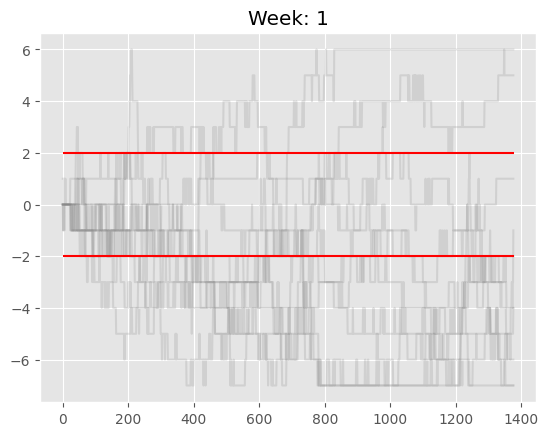

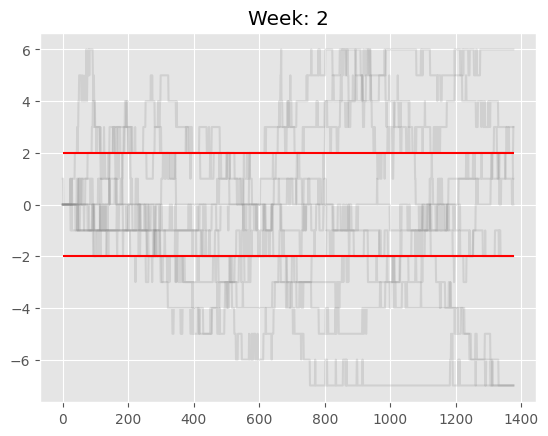

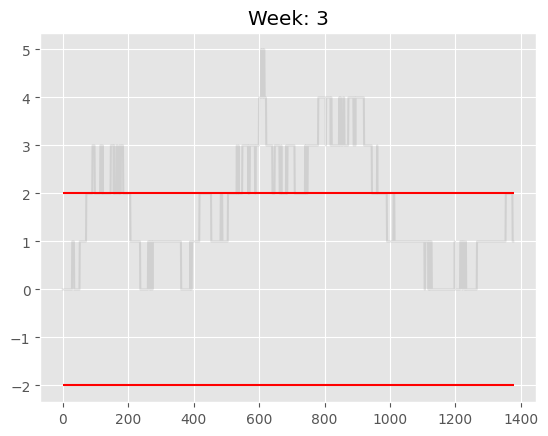

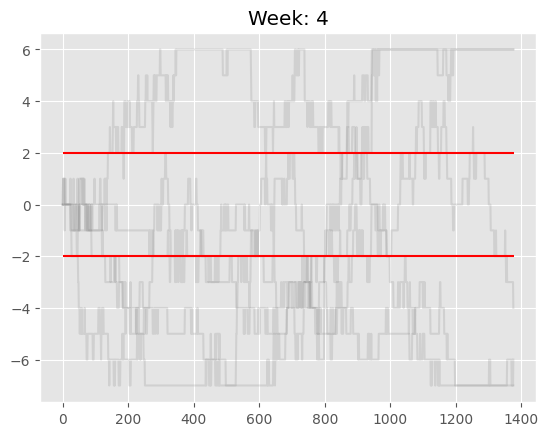

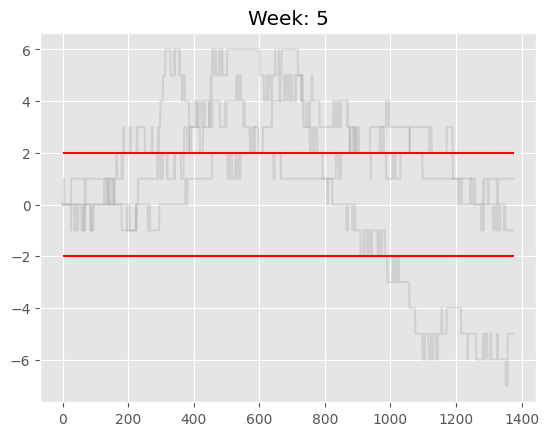

In [41]:
for week_number in range(1, 6):
    path2count_dict = week2path2count[week_number]
    path2count = pd.Series(path2count_dict).copy()
    path2count = path2count.copy()

    pathes_df = (
        path2count.apply(pd.Series)
            .replace('', np.nan)
            .dropna(how='all', axis=1)
            .astype(float)
            .dropna(axis=0)
    )
    plt.title(f'Week: {week_number}')
    for col in pathes_df.index:
        pathes_df.loc[col].plot(alpha=0.2, color='grey')
    plt.hlines(-2, 0, pathes_df.shape[1], color='red')
    plt.hlines(2, 0, pathes_df.shape[1], color='red')
    plt.show()

# For all weeks

In [42]:
start2end_pob = {}
start2end_len = {}
start2end_len_std = {}
start2end_counts = {}

MAX_END = 6
for min_start in range(1, 5):
    row_increasing_patterns = get_increasing_patterns(total_pathes_df, min_start, MAX_END)
    len_till_end = row_increasing_patterns[row_increasing_patterns >= MAX_END-1].apply(first_high_value, axis=1)
    len_till_end_mean = len_till_end.mean()
    len_till_end_std = len_till_end.std()
    probability_pattern = get_percent_increasing(total_pathes_df, min_start, MAX_END)
    start2end_pob[min_start] = probability_pattern
    start2end_len[min_start] = len_till_end_mean
    start2end_len_std[min_start] = len_till_end_std
    start2end_counts[min_start] = row_increasing_patterns.shape[0]

start2end_pob = pd.Series(start2end_pob)
start2end_len = pd.Series(start2end_len)
start2end_len_std = pd.Series(start2end_len_std).round(2)
start2end_counts = pd.Series(start2end_counts)

# create 
start2end_df_start = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                       'len_hours': start2end_len, 
                                       'count': start2end_counts,
                                       'len_hours_std': start2end_len_std})
start2end_df_start['len_days'] = (start2end_df_start['len_hours'] / 24).round(2)
start2end_df_start['end_harmonic'] = MAX_END


start2end_pob = {}
start2end_len = {}
start2end_len_std = {}
start2end_counts = {}
MAX_END = -6
for min_start in range(-1, -5, -1):
    row_increasing_patterns = get_increasing_patterns(total_pathes_df, min_start, MAX_END)
    len_till_end = row_increasing_patterns[row_increasing_patterns <= MAX_END+1].apply(
        first_high_value, axis=1)
    len_till_end_mean = len_till_end.mean()
    len_till_end_std = len_till_end.std()
    probability_pattern = get_percent_increasing(total_pathes_df, min_start, MAX_END)
    start2end_pob[min_start] = probability_pattern
    start2end_len[min_start] = len_till_end_mean
    start2end_len_std[min_start] = len_till_end_std
    start2end_counts[min_start] = row_increasing_patterns.shape[0]

#     start2end_pob = pd.Series(start2end_pob)
#     start2end_len = pd.Series(start2end_len)
#     start2end_len_std = pd.Series(start2end_len_std).round(2)
#     start2end_counts = pd.Series(start2end_counts)

start2end_df_neg = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                       'len_hours': start2end_len, 
                                       'count': start2end_counts,
                                       'len_hours_std': start2end_len_std})
start2end_df_neg['len_days'] = (start2end_df_neg['len_hours'] / 24).round(2)
start2end_df_neg['end_harmonic'] = MAX_END
start2end_df = pd.concat([start2end_df_start, start2end_df_neg], axis=0)

#     print
#     start2end_df.index.name = 'start_harmonic'
start2end_df = start2end_df.reset_index()

start2end_df = start2end_df.rename(columns={'index': 'start_harmonic'})
start2end_df

/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  increasing_harmonic = row[start_index: idx+1]
/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `serie

/tmp/ipykernel_13831/3461457693.py:68: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
/tmp/ipykernel_13831/3461457693.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:]
/tmp/ipykernel_13831/3461457693.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing

/tmp/ipykernel_13831/2409140956.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values
/tmp/ipykernel_13831/2409140956.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  part_row = row[index_of_start_indices[idx]:].values


,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic
0,1,0.051630,316.272727,57,200.920000,13.18,6
1,2,0.059902,430.428571,49,254.460000,17.93,6
2,3,0.088829,445.135135,66,270.300000,18.55,6
3,4,0.165029,490.742424,84,282.100000,20.45,6
4,-1,0.062539,480.439024,100,322.135301,20.02,-6
5,-2,0.076531,570.157895,105,330.651243,23.76,-6
6,-3,0.104147,516.420000,113,326.311738,21.52,-6
7,-4,0.166474,495.472527,144,301.089811,20.64,-6


# Window size and predictability

In [43]:
X = pd.DataFrame(total_pathes_df.index.map(diapazon_ser), index=total_pathes_df.index)
X

,0
2020-10,71.50
2020-11,114.75
2020-12,154.75
2020-13,219.75
2020-14,168.50
...,...
2023-7,70.50
2023-8,77.50
2023-9,40.25
2024-1,62.50


In [44]:
value_counts_df = pd.DataFrame()
for week_diapazon in total_pathes_df.index:
    value_counts = total_pathes_df.loc[week_diapazon].value_counts(normalize=True)
    value_counts_df = pd.concat([value_counts_df, value_counts], axis=1)
value_counts_df = value_counts_df.T.fillna(0)
value_counts_df

,6.0,3.0,4.0,2.0,1.0,5.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0
2020-10,0.321033,0.222140,0.162362,0.160148,0.056089,0.046494,0.027306,0.004428,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2020-11,0.001477,0.124815,0.059823,0.101182,0.081979,0.024372,0.317578,0.199409,0.089365,0.000000,0.000000,0.000000,0.000000,0.0
2020-12,0.000000,0.000000,0.000000,0.001477,0.035451,0.000000,0.118168,0.099705,0.172083,0.369276,0.155096,0.048744,0.000000,0.0
2020-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070901,0.115953,0.462334,0.289513,0.061300,0.000000,0.000000,0.0
2020-14,0.000000,0.000000,0.000000,0.000000,0.006647,0.000000,0.068685,0.176514,0.395126,0.286558,0.066470,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,0.000000,0.121809,0.018235,0.270605,0.186725,0.000000,0.385850,0.016776,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2023-8,0.000000,0.000000,0.000000,0.029818,0.232727,0.000000,0.186182,0.362182,0.189091,0.000000,0.000000,0.000000,0.000000,0.0
2023-9,0.000000,0.002909,0.000000,0.033455,0.080727,0.000000,0.130909,0.076364,0.059636,0.112000,0.339636,0.136000,0.028364,0.0
2024-1,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.598958,0.026042,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### Pearson Corr

In [45]:
value_counts_df['diapazon_width'] = X
pearsonr = value_counts_df.corr()['diapazon_width'].drop('diapazon_width').sort_values()
pearsonr

-7.0   -0.354106
-6.0   -0.349066
-5.0   -0.347794
-4.0   -0.223015
6.0    -0.207717
5.0     0.001905
4.0     0.048592
3.0     0.112394
-3.0    0.124985
-1.0    0.230430
0.0     0.257706
-2.0    0.277042
2.0     0.290115
1.0     0.367399
Name: diapazon_width, dtype: float64

In [46]:
from scipy.stats import pearsonr
MAX_P_VALUE = 0.05
pearson_corr = pd.Series()
for col in value_counts_df.drop('diapazon_width', axis=1).columns:
    corr, p_value = pearsonr(value_counts_df[col], value_counts_df['diapazon_width'])
    if p_value <= MAX_P_VALUE:
        pearson_corr[col] = corr
pearson_corr.sort_values()

/tmp/ipykernel_13831/2892913279.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pearson_corr = pd.Series()


-7.0   -0.354106
-6.0   -0.349066
-5.0   -0.347794
-4.0   -0.223015
 6.0   -0.207717
-1.0    0.230430
 0.0    0.257706
-2.0    0.277042
 2.0    0.290115
 1.0    0.367399
dtype: float64

/tmp/ipykernel_13831/957352432.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  spearman_corr = pd.Series()


<Axes: >

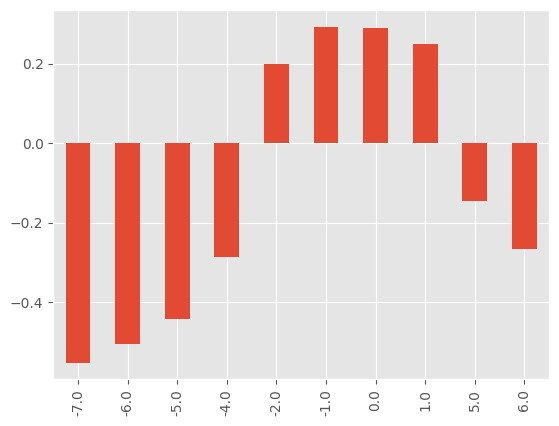

In [47]:
from scipy.stats import spearmanr
MAX_P_VALUE = 0.05
spearman_corr = pd.Series()
for col in value_counts_df.drop('diapazon_width', axis=1).columns:
    corr, p_value = spearmanr(value_counts_df[col], value_counts_df['diapazon_width'])
    if p_value <= MAX_P_VALUE:
        spearman_corr[col] = corr
spearman_corr.sort_index().plot(kind='bar')

# Find Resitances & Support

In [48]:
prices = es_df['close']
diapazon_week = '2020-7'
predefined_level = harmonics.loc[diapazon_week, 1]
harmonic_window = diapazon_ser[diapazon_week]
percentage_threshold = 0.25
MIN_PERC_DECREASE = 0.15
print(harmonic_window * MIN_PERC_DECREASE)

shift_grey_zone = 3
WINDOW = 3

local_dip_condition = True
for window in range(1, WINDOW+1):    
    local_dip_condition = (
        local_dip_condition 
        & (prices <= prices.shift(window))
        & (prices <= prices.shift(-window))
    )
local_dip_condition = (
    local_dip_condition 
    & (prices <= (prices.shift(WINDOW+1) - harmonic_window * MIN_PERC_DECREASE))
    & (prices <= (prices.shift(-WINDOW-1) - harmonic_window * MIN_PERC_DECREASE))
)    
    

local_peak_condition = True
for window in range(1, WINDOW+1):    
    local_peak_condition = (
        local_peak_condition 
        & (prices >= prices.shift(window))
        & (prices >= prices.shift(-window))
    )
    
local_peak_condition = (
    local_peak_condition 
    & (prices >= (prices.shift(WINDOW+1) + harmonic_window * MIN_PERC_DECREASE))
    & (prices >= (prices.shift(-WINDOW-1) + harmonic_window * MIN_PERC_DECREASE))
)
    
# check price levels
upper_bound = predefined_level + harmonic_window * percentage_threshold
lower_bound = predefined_level - harmonic_window * percentage_threshold
past_not_grey = (
    (prices.shift(shift_grey_zone) >= upper_bound) 
    | (prices.shift(shift_grey_zone) <= lower_bound)
)
future_not_grey = (prices.shift(-shift_grey_zone) >= upper_bound) | (prices.shift(-shift_grey_zone) <= lower_bound)
# future_not_grey = (prices.shift(-shift_grey_zone) <= lower_bound)
local_not_in_grey_zone_condition = past_not_grey | future_not_grey
# is price in grey zone
in_zone_condition = (prices <= upper_bound) & (prices >= lower_bound)
# get price values for support and resistance
condition_support = local_dip_condition & in_zone_condition & future_not_grey
condition_resistance = local_peak_condition & in_zone_condition & past_not_grey
resistance_levels = prices[condition_resistance]
support_levels = prices[condition_support]
print('Upper bound', upper_bound, 'lower bound', lower_bound)
print('# resistances', resistance_levels.shape[0], '# of supports:', support_levels.shape[0])
resistance_levels

2.625
Upper bound 3359.625 lower bound 3350.875
# resistances 5 # of supports: 6


time
2020-02-06 05:00:00+00:00    3353.50
2020-08-10 05:00:00+00:00    3354.75
2020-09-17 14:00:00+00:00    3351.50
2020-09-17 22:00:00+00:00    3355.25
2020-10-02 16:00:00+00:00    3354.00
Name: close, dtype: float64

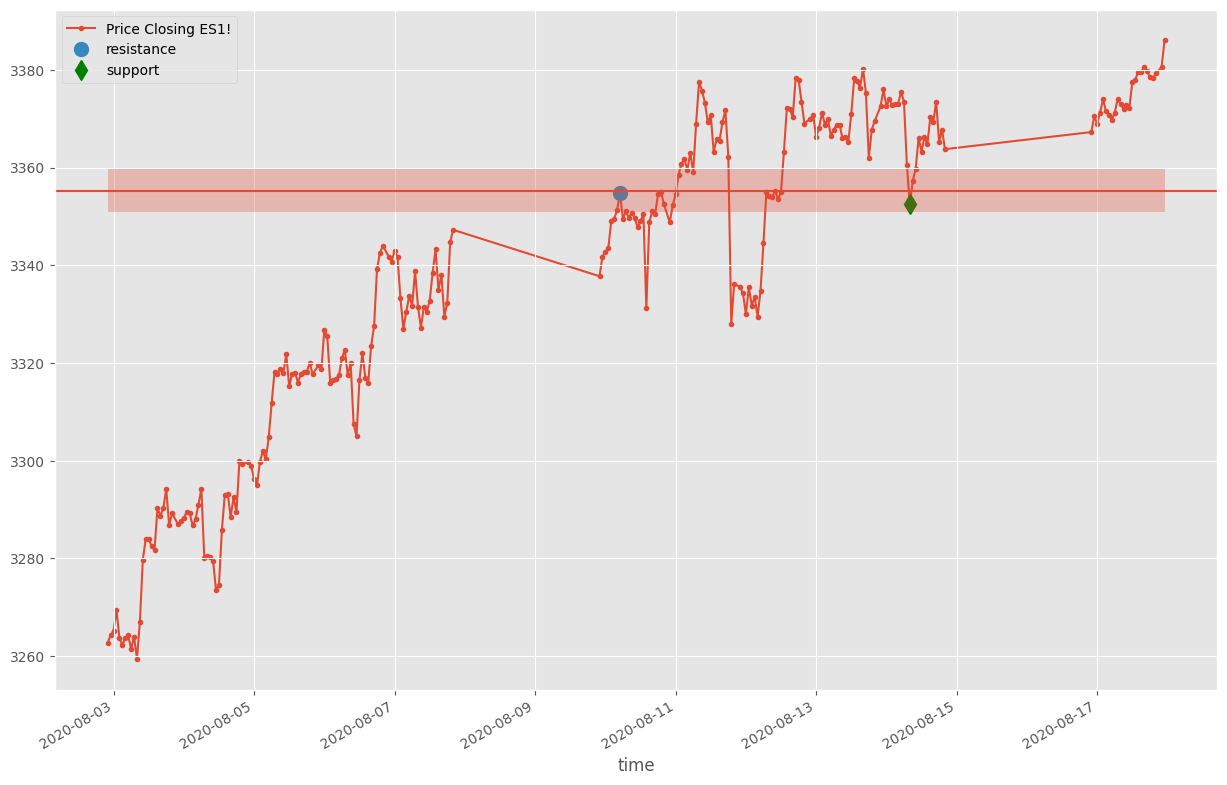

In [49]:
min_date = '2020-08-01'
max_date = '2020-08-17'
prices[min_date:max_date].plot(figsize=(15, 10), zorder=0, marker='o', markersize=3, label='Price Closing ES1!')
resistance_levels[min_date:max_date].plot(marker='o', linestyle='', markersize=10, zorder=1, label='resistance')
support_levels[min_date:max_date].plot(marker='d', linestyle='', markersize=10, zorder=1, color='green', label='support')
plt.fill_between(prices[min_date:max_date].index, 
                 upper_bound,
                 lower_bound, 
                 alpha=0.3)
plt.axhline(predefined_level)
plt.legend();

In [50]:
shift_grey_zone = 7
percentage_threshold = 0.25
MIN_PERC_DECREASE = 0.05
WINDOW = 3
prices = es_df['close']
resistance_support_table = pd.DataFrame(index=es_df.index, columns=harmonics.index)
# es_df = es_df.assign(level_harmonic=None)

for diapazon_week in harmonics.index:
    for harmonic_level in harmonics.columns:
        harmonic_window = diapazon_ser[diapazon_week]
        predefined_level = harmonics.loc[diapazon_week, harmonic_level]
        upper_bound = predefined_level + harmonic_window * percentage_threshold
        lower_bound = predefined_level - harmonic_window * percentage_threshold
        

        local_dip_condition = True
        for window in range(1, WINDOW+1):    
            local_dip_condition = (
                local_dip_condition 
                & (prices <= prices.shift(window)) 
                & (prices <= prices.shift(-window))
            )
            
        local_dip_condition = (
            local_dip_condition 
#             & (prices <= (prices.shift(WINDOW+1) - harmonic_window * MIN_PERC_DECREASE))
            & (prices <= (prices.shift(-WINDOW-2) - harmonic_window * MIN_PERC_DECREASE))
        )    

        local_peak_condition = True
        for window in range(1, WINDOW+1):    
            local_peak_condition = (
                local_peak_condition 
                & (prices >= prices.shift(window)) 
                & (prices >= prices.shift(-window))
            )
        
        local_peak_condition = (
            local_peak_condition 
#             & (prices >= (prices.shift(WINDOW+1) + harmonic_window * MIN_PERC_DECREASE))
            & (prices >= (prices.shift(-WINDOW-2) + harmonic_window * MIN_PERC_DECREASE))
        )
        
        # check price levels
        past_not_grey = (
            (prices.shift(shift_grey_zone) >= upper_bound) 
            | (prices.shift(shift_grey_zone) <= lower_bound)
        )
        future_not_grey = (
            (prices.shift(-shift_grey_zone) >= upper_bound) 
            | (prices.shift(-shift_grey_zone) <= lower_bound)
        )
        local_not_in_grey_zone_condition = past_not_grey | future_not_grey
        # is price in grey zone
        in_zone_condition = (prices <= upper_bound) & (prices >= lower_bound)
        # get price values for support and resistance
        condition_support = local_dip_condition & in_zone_condition & future_not_grey
        condition_resistance = local_peak_condition & in_zone_condition #& past_not_grey
        
        resistance_support_table.loc[condition_resistance, f'{diapazon_week}'] = f'{harmonic_level}r'
        resistance_support_table.loc[condition_support, f'{diapazon_week}'] = f'{harmonic_level}s'
        
resistance_support_table.count()

diapazan_week
2020-10    276
2020-11    253
2020-12    182
2020-13    269
2020-14    234
          ... 
2023-7     815
2023-8     841
2023-9     574
2024-1     299
2024-2     108
Length: 209, dtype: int64

In [51]:
def filter_out_close_supports_resistance(hormonic_res_sup_values, min_distance_days: int = 1):
    dates_ser = pd.Series(hormonic_res_sup_values.index)
    too_short_distance = (dates_ser - dates_ser.shift(1)).dt.days < min_distance_days
    same_value = hormonic_res_sup_values == hormonic_res_sup_values.shift(1)
    hormonic_res_sup_values[too_short_distance.values & same_value] = np.nan
    return hormonic_res_sup_values

In [52]:
print(resistance_support_table.count().sum())
min_distance_days = 2
for col in resistance_support_table.columns:
    hormonic_res_sup_values = resistance_support_table[col].dropna()
    hormonic_res_sup_values = filter_out_close_supports_resistance(hormonic_res_sup_values, min_distance_days)
    resistance_support_table[col] = hormonic_res_sup_values
print(resistance_support_table.count().sum())

110363
68317


[ 1  0  2 -1  3]


<Axes: title={'center': 'All resistance for 2021-2 harmonics'}, xlabel='time'>

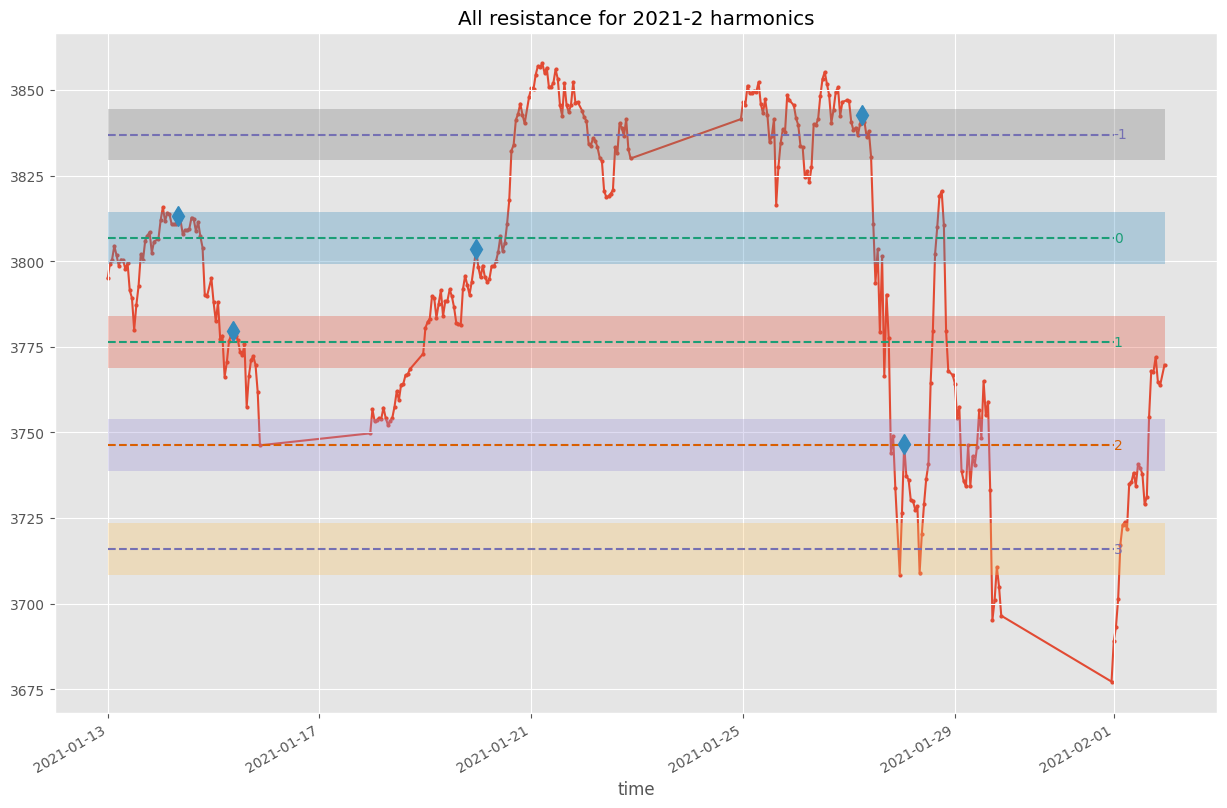

In [53]:
diapazon_week = '2021-2'
min_date = '2021-01-13'
max_date = '2021-02-01'
harmonic_window = diapazon_ser[diapazon_week]
hormonic_res_sup_values = resistance_support_table[diapazon_week].dropna()
unique_met_hormonics = hormonic_res_sup_values[min_date: max_date].str[:-1].astype(int).unique()
print(unique_met_hormonics)
is_resist = hormonic_res_sup_values[hormonic_res_sup_values.str[-1] == 'r'].str[:-1]
is_support = hormonic_res_sup_values[hormonic_res_sup_values.str[-1] == 's'].str[:-1]
plt.figure(figsize=(15, 10), )
prices.loc[min_date: max_date].plot(zorder=0, marker='o', 
                                    markersize=2,
                                    title=f'All resistance for {diapazon_week} harmonics')

    
colormap = colormaps['Dark2']  # You can choose a different colormap
# Generate a list of unique colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, harmonics.shape[1])]

for idx, level in enumerate(unique_met_hormonics):
    haromonics_levels_week = es_df['diapazan_week'].map({diapazon_week: harmonics.loc[diapazon_week, level]})
    harmonic_level_week = harmonics.loc[diapazon_week, level]
    upper_bound = harmonic_level_week + harmonic_window * percentage_threshold
    lower_bound = harmonic_level_week - harmonic_window * percentage_threshold
    
    plt.hlines(harmonic_level_week, min_date, max_date, color=colors[idx], linestyle='--')
    plt.fill_between(prices.loc[min_date: max_date].index, lower_bound, upper_bound, alpha=0.3)
    plt.text(max_date, harmonic_level_week, f'{level}', color=colors[idx],
             verticalalignment='center', horizontalalignment='left')
    
prices.loc[is_resist[min_date: max_date].index].plot(marker='d', linestyle='', markersize=10)

In [54]:
harmonic_window = diapazon_ser[diapazon_week]
harmonic_level = -5
predefined_level = harmonics.loc[diapazon_week, harmonic_level]
WINDOW = 3
shift_grey_zone = 7
local_dip_condition = True
for window in range(1, WINDOW+1):    
    local_dip_condition = (
        local_dip_condition 
        & (prices <= prices.shift(window)) 
        & (prices <= prices.shift(-window))
    )

local_dip_condition = (
    local_dip_condition 
#     & (prices <= (prices.shift(WINDOW+1) - harmonic_window * MIN_PERC_DECREASE))
    & (prices <= (prices.shift(-WINDOW-1) - harmonic_window * MIN_PERC_DECREASE))
)    

local_peak_condition = True
for window in range(1, WINDOW+1):    
    local_peak_condition = (
        local_peak_condition 
        & (prices >= prices.shift(window)) 
        & (prices >= prices.shift(-window))
    )

local_peak_condition = (
    local_peak_condition 
#     & (prices >= (prices.shift(WINDOW+1) + harmonic_window * MIN_PERC_DECREASE))
    & (prices >= (prices.shift(-WINDOW-2) + harmonic_window * MIN_PERC_DECREASE))
)

# check price levels
upper_bound = predefined_level + harmonic_window * percentage_threshold
lower_bound = predefined_level - harmonic_window * percentage_threshold
past_not_grey = (
    (prices.shift(shift_grey_zone) >= upper_bound) 
    | (prices.shift(shift_grey_zone) <= lower_bound)
)
future_not_grey = (
    (prices.shift(-shift_grey_zone) >= upper_bound) 
    | (prices.shift(-shift_grey_zone) <= lower_bound)
)
local_not_in_grey_zone_condition = past_not_grey | future_not_grey
# is price in grey zone
in_zone_condition = (prices <= upper_bound) & (prices >= lower_bound)
# get price values for support and resistance
condition_support = local_dip_condition & in_zone_condition & future_not_grey
condition_resistance = local_peak_condition & in_zone_condition & past_not_grey


condition_df = pd.DataFrame(index=prices.index)
condition_df['prices'] = prices
condition_df['upper_bound'] = upper_bound
condition_df['lower_bound'] = lower_bound
condition_df['condition_resistance'] = condition_resistance
condition_df['local_peak_condition'] = local_peak_condition
condition_df['in_zone_condition'] = in_zone_condition
condition_df['past_not_grey'] = past_not_grey
condition_df['is_enough_increase_past'] = (
    (prices >= (prices.shift(WINDOW+1) + harmonic_window * MIN_PERC_DECREASE))
)
condition_df['is_enough_increase_future'] = (
(prices >= (prices.shift(-WINDOW-1) + harmonic_window * MIN_PERC_DECREASE))
)
print(condition_df.loc['2021-02-15': '2021-02-16', 'condition_resistance'].any())

condition_df.loc['2021-02-15': '2021-02-16']

True


,prices,upper_bound,lower_bound,condition_resistance,local_peak_condition,in_zone_condition,past_not_grey,is_enough_increase_past,is_enough_increase_future
time,,,,,,,,,
2021-02-15 00:00:00+00:00,3943.75,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 01:00:00+00:00,3944.00,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 02:00:00+00:00,3944.75,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 03:00:00+00:00,3947.00,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 04:00:00+00:00,3946.25,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 05:00:00+00:00,3946.25,3965.5625,3950.4375,False,False,False,True,True,False
2021-02-15 06:00:00+00:00,3945.50,3965.5625,3950.4375,False,False,False,True,False,False
2021-02-15 07:00:00+00:00,3946.00,3965.5625,3950.4375,False,False,False,True,False,False
2021-02-15 08:00:00+00:00,3948.00,3965.5625,3950.4375,False,False,False,True,True,True


<Axes: title={'center': 'All support for 2021-2 harmonics'}, xlabel='time'>

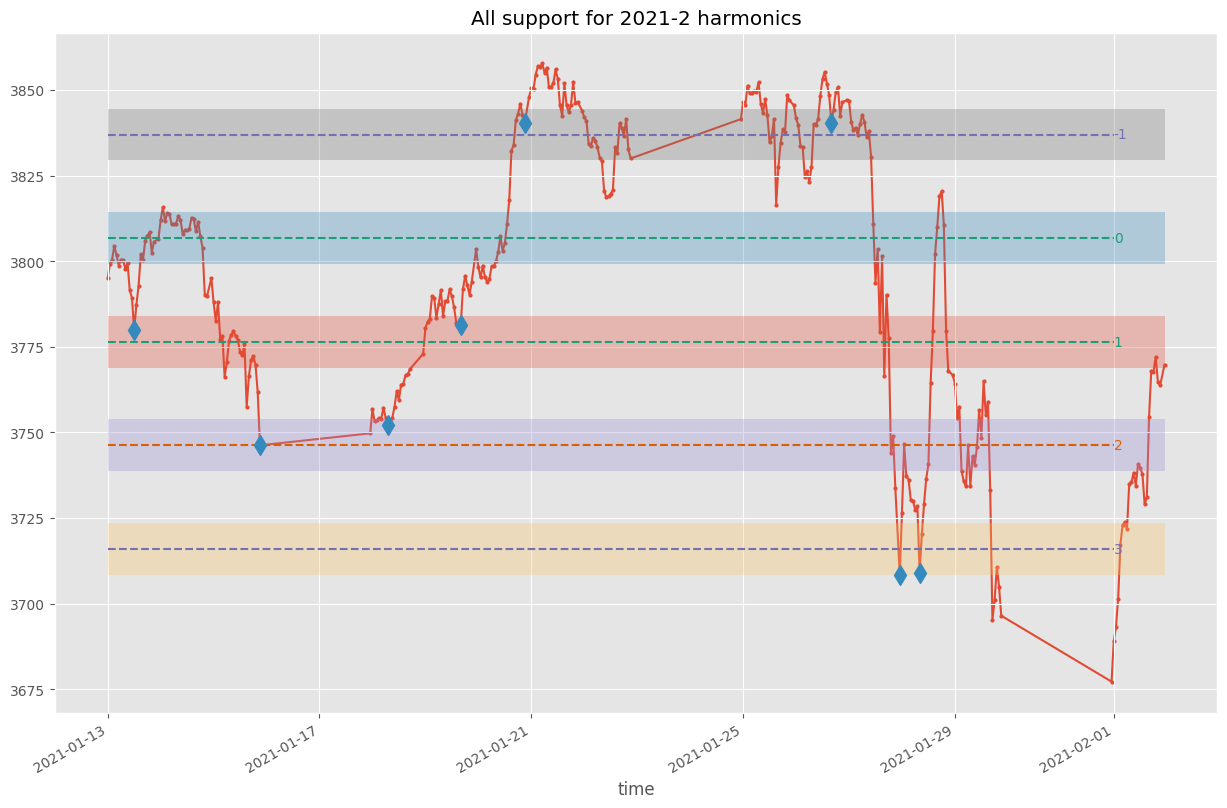

In [55]:
plt.figure(figsize=(15, 10), )
prices.loc[min_date: max_date].plot(zorder=0, marker='o', 
                                    markersize=2,
                                    title=f'All support for {diapazon_week} harmonics')

for idx, level in enumerate(unique_met_hormonics):
    haromonics_levels_week = es_df['diapazan_week'].map({diapazon_week: harmonics.loc[diapazon_week, level]})
    harmonic_level_week = harmonics.loc[diapazon_week, level]
    upper_bound = harmonic_level_week + harmonic_window * percentage_threshold
    lower_bound = harmonic_level_week - harmonic_window * percentage_threshold

    plt.hlines(harmonic_level_week, min_date, max_date, color=colors[idx], linestyle='--')
    plt.fill_between(prices.loc[min_date: max_date].index, lower_bound, upper_bound, alpha=0.3)
    plt.text(max_date, harmonic_level_week, f'{level}', color=colors[idx],
             verticalalignment='center', horizontalalignment='left')
    
prices.loc[is_support[min_date: max_date].index].plot(marker='d', linestyle='', markersize=10)

In [56]:
window = 12
granularity = '1h'
total_pathes_dates_df = resistance_support_table.copy()

for diapozon_week, price_harmonic in total_pathes_df.iterrows():
    start_date = es_df[
        (es_df['diapazan_week'] == diapozon_week) & (~es_df['is_diapazon_day'])
    ].index.min()
    end_date = start_date + pd.Timedelta(window, unit='w')

    dates_future = es_df.loc[start_date: end_date, 'close'].dropna().index
    price_harmonic = price_harmonic.copy().dropna()
    price_harmonic.index = dates_future
    total_pathes_dates_df[diapozon_week] = price_harmonic
total_pathes_dates_df.tail()

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2024-01-12 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0
2024-01-12 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0
2024-01-12 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0
2024-01-12 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0
2024-01-12 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0


In [57]:
diapazon_week2harmon_start_date = (
    es_df.reset_index().query("is_diapazon_day == False")
    .groupby('diapazan_week')['time'].first()
)
diapazon_week2harmon_start_date

diapazan_week
2020-10   2020-03-03 14:00:00+00:00
2020-11   2020-03-10 14:00:00+00:00
2020-12   2020-03-17 14:00:00+00:00
2020-13   2020-03-24 14:00:00+00:00
2020-14   2020-03-31 14:00:00+00:00
                     ...           
2023-7    2023-02-14 14:00:00+00:00
2023-8    2023-02-21 14:00:00+00:00
2023-9    2023-02-28 14:00:00+00:00
2024-1    2024-01-02 14:00:00+00:00
2024-2    2024-01-09 14:00:00+00:00
Name: time, Length: 209, dtype: datetime64[ns, UTC]

In [61]:
def remove_duplicates(input_string):
    cleaned_path = []
    last_char = None

    for char in input_string:
        if char != last_char:
            cleaned_path.append(char)
            last_char = char

    return cleaned_path

In [70]:
# clustering on pure harmonics levels

In [190]:
N_DAYS = 5
value2streak_length_dict = {}
for col in resistance_support_table.columns:
    values = resistance_support_table[col].dropna()#.loc[:'2020-']
    min_date = diapazon_week2harmon_start_date[col]
    max_date = min_date + pd.Timedelta(N_DAYS, 'days')
    values = values[min_date:max_date]
#     values = pd.Series(remove_duplicates(values))
    value2streak_length = defaultdict(int)
    
    # find number of stuff
    harmonic2last_meet_len = defaultdict(int)
    for query_harmonic in range(-7, 8):
        for resistance_support_value in values:
            if int(resistance_support_value[:-1]) == query_harmonic:
                value2streak_length[query_harmonic] += 1
                harmonic2last_meet_len[query_harmonic] = 0
            harmonic2last_meet_len[query_harmonic] += 1
            
            if harmonic2last_meet_len[query_harmonic] > 2:
                break
    value2streak_length_dict[col] = value2streak_length
    

X_res_sup = pd.DataFrame(value2streak_length_dict).T 
max_value = X_res_sup.max().max()
print(max_value)
X_res_sup = X_res_sup / max_value
X_res_sup = X_res_sup.sort_index(axis=1)
X_res_sup = X_res_sup.loc[:, X_res_sup.count() > 2].fillna(0)
X_res_sup

4.0


,-2,-1,0,1,2,3
2020-10,0.0,0.00,0.25,0.50,0.00,0.0
2020-11,0.0,0.00,0.25,0.75,0.00,0.0
2020-12,0.0,0.00,0.50,0.25,0.00,0.0
2020-13,0.0,0.00,0.25,0.00,0.00,0.0
2020-14,0.0,0.00,0.00,0.50,0.00,0.0
...,...,...,...,...,...,...
2023-7,0.0,0.00,0.00,0.25,0.25,0.0
2023-8,0.0,0.00,0.00,0.25,0.00,0.0
2023-9,0.0,0.00,0.00,0.50,0.25,0.0
2024-1,0.0,0.00,0.00,0.75,0.25,0.0


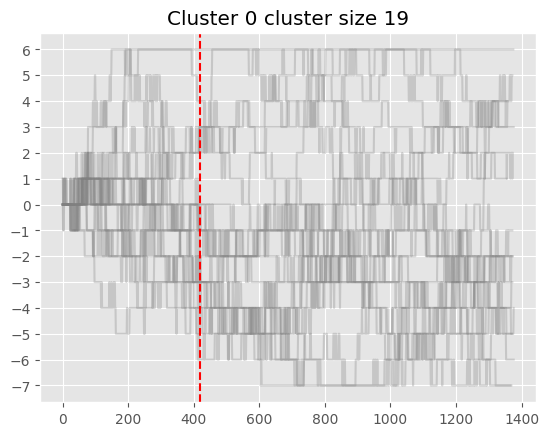

0    0.25
1    0.50
dtype: float64
---------------------------------------------


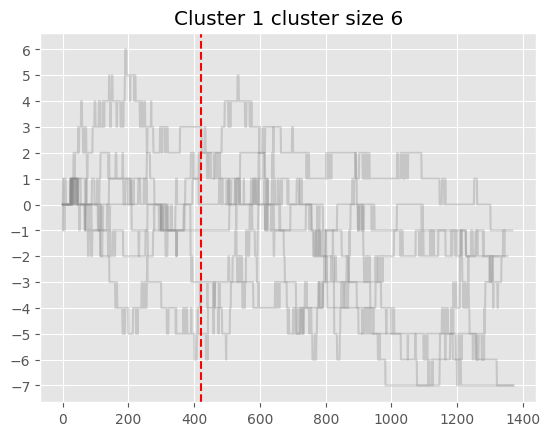

0    0.25
1    0.75
dtype: float64
---------------------------------------------


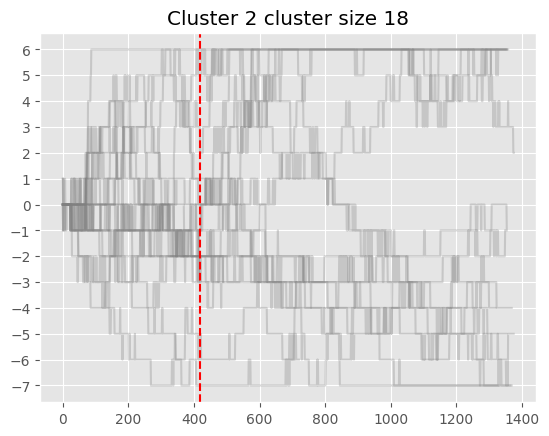

0    0.50
1    0.25
dtype: float64
---------------------------------------------


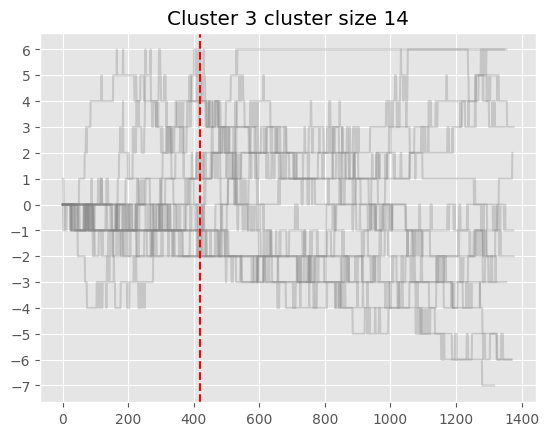

0    0.25
dtype: float64
---------------------------------------------


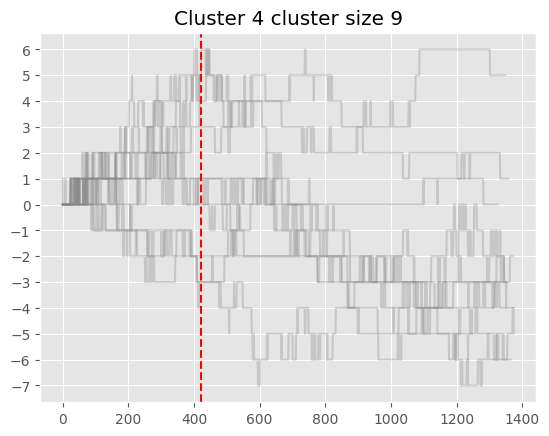

1    0.5
dtype: float64
---------------------------------------------


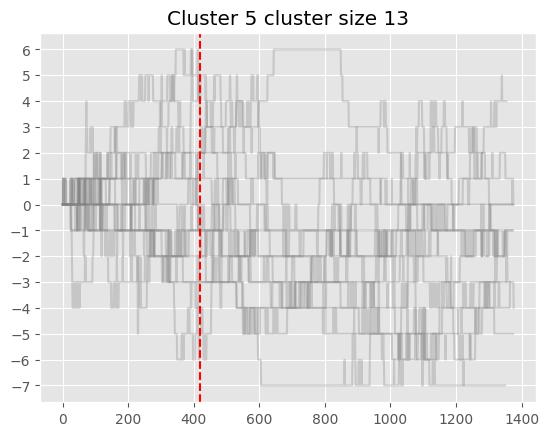

1    0.25
dtype: float64
---------------------------------------------


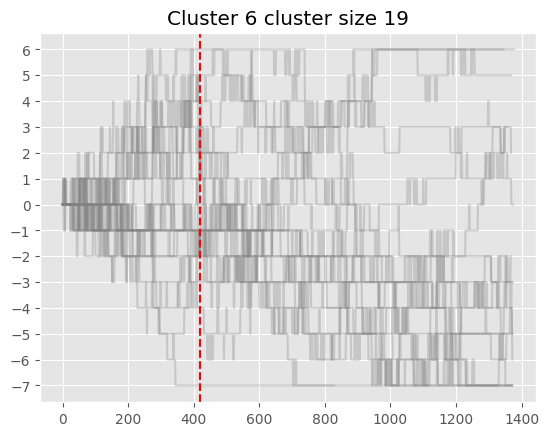

0    0.25
1    0.25
dtype: float64
---------------------------------------------


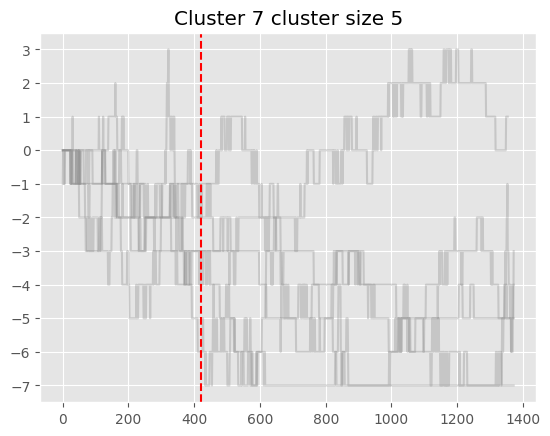

0    0.75
1    0.25
dtype: float64
---------------------------------------------


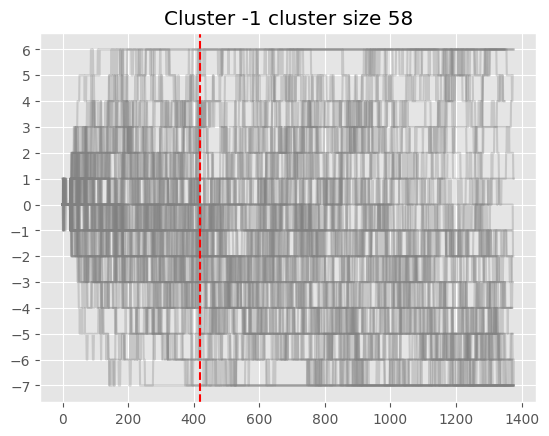

-2    0.025862
-1    0.086207
 0    0.215517
 1    0.306034
 2    0.120690
 3    0.047414
dtype: float64
---------------------------------------------


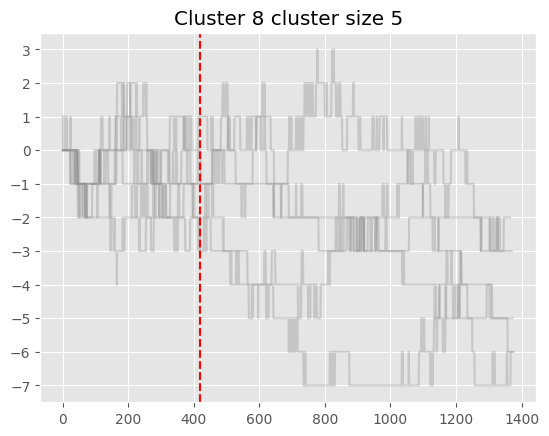

-1    0.25
 0    0.25
dtype: float64
---------------------------------------------


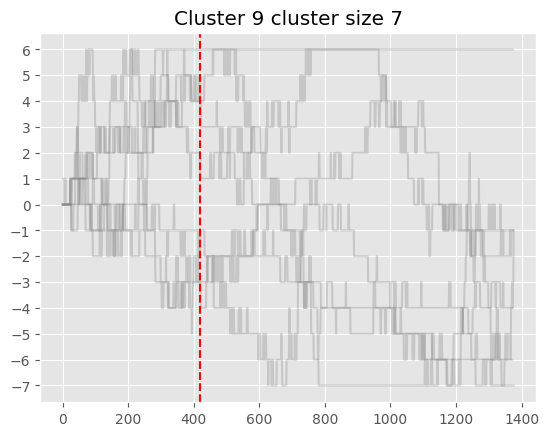

0    0.25
1    0.25
2    0.25
dtype: float64
---------------------------------------------


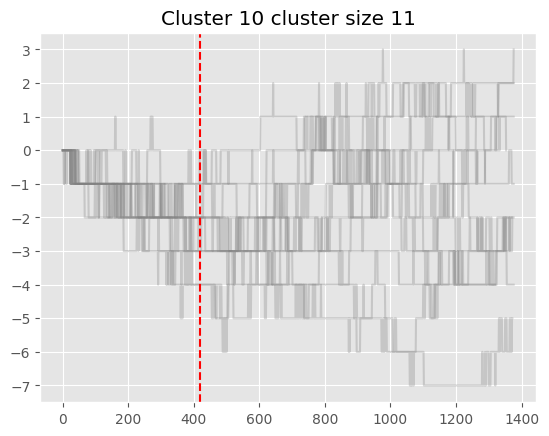

0    0.5
dtype: float64
---------------------------------------------


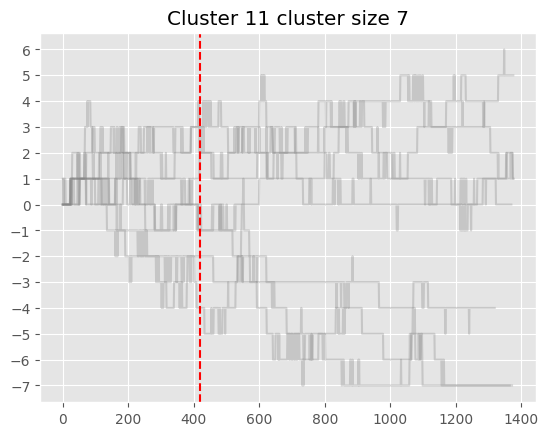

1    0.25
2    0.25
dtype: float64
---------------------------------------------


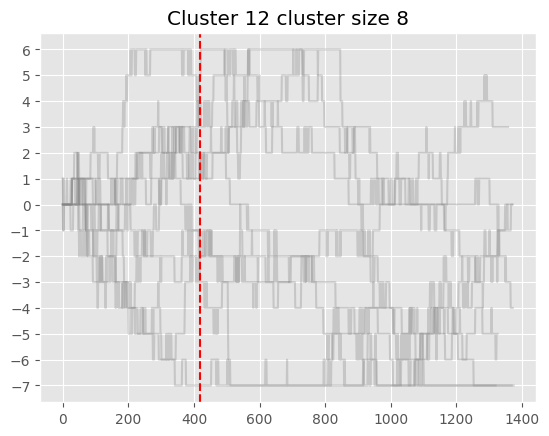

0    0.5
1    0.5
dtype: float64
---------------------------------------------


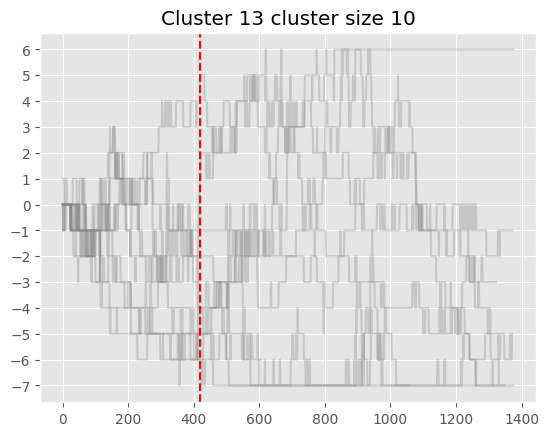

-1    0.25
 0    0.25
 1    0.25
dtype: float64
---------------------------------------------


In [197]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN, AgglomerativeClustering
from matplotlib.ticker import MultipleLocator

cluster_model = DBSCAN(eps=0.1)
labels = cluster_model.fit_predict(X_res_sup)
labels = pd.Series(labels)
LEN_GRAPH  = N_DAYS * 4 * 21

for label in labels.unique():
    weeks = X_res_sup[(labels==label).values].index
    cluster_df = total_pathes_df.loc[weeks][:2*LEN_GRAPH]
    plt.title(f'Cluster {label} cluster size {cluster_df.shape[0]}')
    for diapazon_week in cluster_df.index:
        cluster_df.loc[diapazon_week].plot(alpha=0.3, color='grey')
    y_major_locator = MultipleLocator(1)  
    plt.gca().yaxis.set_major_locator(y_major_locator)
    plt.axvline(LEN_GRAPH, color='red', linestyle='--', label='analysis period')
    plt.show()
    print(X_res_sup[(labels==label).values].mean(axis=0).replace(0, np.nan).dropna())
    print('-' * 45)

# Resistance Support Path filled with values

In [262]:
resistance_support_table_filled = resistance_support_table.copy()
MIN_VALUE = -7
N_DAYS = 5
total_pathes_dates_df_normalized = -total_pathes_dates_df - MIN_VALUE
for col in total_pathes_dates_df_normalized.columns:
    path_ser = total_pathes_dates_df_normalized[col]
    temp_path_ser = resistance_support_table[col].fillna(path_ser).copy()
    min_date = diapazon_week2harmon_start_date[col]
    max_date = min_date + pd.Timedelta(N_DAYS, 'days')
    temp_path_ser[:min_date] = np.nan
    temp_path_ser[max_date:] = np.nan
    resistance_support_table_filled[col] = temp_path_ser
resistance_support_table_filled.count()

diapazan_week
2020-10    76
2020-11    75
2020-12    75
2020-13    75
2020-14    75
           ..
2023-7     76
2023-8     76
2023-9     76
2024-1     76
2024-2     76
Length: 209, dtype: int64

In [199]:
filled_path_dict = {}

for col, temp_path_ser in resistance_support_table_filled.T.iterrows():
    temp_path_ser = temp_path_ser.dropna()
    prev_line = None
    fill_value = np.nan
    filled_path_list = []
    for idx, (time_idx, value) in enumerate(temp_path_ser.items()):
        if isinstance(value, str):
            if 'r' in value:
                prev_line = 'resistance'
                fill_value = np.inf
                value = -int(value[:-1]) - MIN_VALUE#) + 'r' 
            else:
                prev_line = 'support'
                fill_value = -np.inf
                value = -int(value[:-1]) - MIN_VALUE#) + 's'
            filled_path_list.append(value)


        else:
            if prev_line == 'resistance':
                fill_value = min(value, fill_value)
            elif prev_line == 'support':
                fill_value = max(value, fill_value)
            if not np.isnan(fill_value) and (
                idx + 1 > len(temp_path_ser) - 1
                or isinstance(temp_path_ser.iloc[idx+1], str)
            ):
                filled_path_list.append(fill_value)
    filled_path_dict[col] = filled_path_list
filled_path_df = pd.Series(filled_path_dict).apply(pd.Series)
filled_path_df.describe()

/tmp/ipykernel_13831/1072052947.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filled_path_df = pd.Series(filled_path_dict).apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,208.000000,208.000000,179.000000,177.000000,118.000000,115.000000,57.000000,52.000000,24.000000,21.000000,9.000000,8.000000,4.00,2.000000,1.0
mean,6.456731,6.985577,6.441341,6.983051,6.635593,6.973913,6.649123,7.134615,6.500000,6.571429,5.333333,5.625000,6.25,6.500000,5.0
std,0.627896,0.955424,1.049703,1.294545,1.343966,1.564187,1.586677,1.572170,1.744557,2.292846,2.345208,2.326094,0.50,0.707107,NaN
min,3.000000,4.000000,3.000000,3.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,2.000000,6.00,6.000000,5.0
25%,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,5.000000,5.000000,6.00,6.250000,5.0
50%,6.000000,7.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,7.000000,7.000000,6.000000,6.500000,6.00,6.500000,5.0
75%,7.000000,7.000000,7.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,6.25,6.750000,5.0
max,9.000000,12.000000,11.000000,13.000000,12.000000,13.000000,10.000000,10.000000,9.000000,10.000000,8.000000,8.000000,7.00,7.000000,5.0


# DTW

1.4615384615384615


<Axes: >

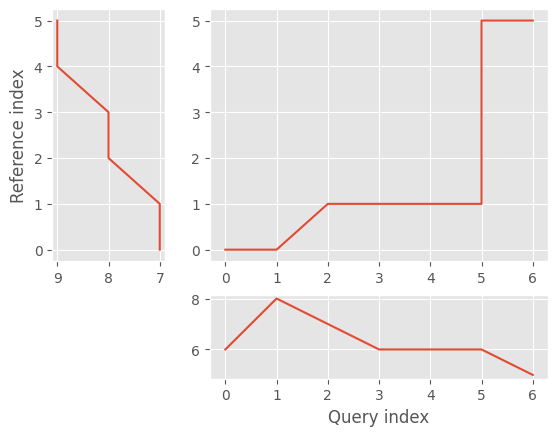

In [200]:
from dtw import dtw
a = filled_path_df.loc['2021-2'].dropna().astype(int)#.tolist()
b = filled_path_df.loc['2021-1'].dropna().astype(int)#.tolist()
alignment = dtw(a, b, keep_internals=True)
normalized_distance = alignment.normalizedDistance
print(normalized_distance)
## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

In [222]:
X = []
for col in filled_path_df.index:
    values = filled_path_df.loc[col].dropna().astype(int)    
    values = remove_duplicates(values)
    X.append(values)
X = pd.DataFrame(X, index=resistance_support_table.columns)
X.shape

(209, 10)

In [223]:
X = X.loc[:, X.count(axis=0) > 2]
X = X[X.count(axis=1) > 2]
max_value = X.max().max()
X = X / max_value
print(X.shape)
X

(150, 9)


,0,1,2,3,4,5,6,7,8
diapazan_week,,,,,,,,,
2020-10,0.461538,0.615385,0.538462,0.461538,0.384615,0.461538,NaN,NaN,NaN
2020-11,0.461538,0.538462,0.461538,0.538462,0.461538,0.384615,0.230769,NaN,NaN
2020-12,0.538462,0.461538,0.538462,0.461538,NaN,NaN,NaN,NaN,NaN
2020-16,0.538462,0.461538,0.615385,NaN,NaN,NaN,NaN,NaN,NaN
2020-18,0.461538,0.615385,0.538462,0.615385,0.461538,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-6,0.461538,0.538462,0.461538,0.538462,0.461538,0.384615,0.461538,NaN,NaN
2023-7,0.461538,0.538462,0.384615,0.461538,NaN,NaN,NaN,NaN,NaN
2023-9,0.461538,0.538462,0.461538,0.384615,0.692308,NaN,NaN,NaN,NaN


### Precompute distances

In [224]:
from sklearn.metrics import pairwise_distances
def dtw_metric(a, b):
    return dtw(a[a > 0], b[b > 0], keep_internals=True).normalizedDistance
dtw_matrix = pairwise_distances(X.fillna(0), metric=dtw_metric)
print(dtw_matrix.shape)
dtw_matrix

(150, 150)


array([[0.        , 0.04142012, 0.03076923, ..., 0.04195804, 0.01398601,
        0.04142012],
       [0.04142012, 0.        , 0.03496503, ..., 0.05769231, 0.03205128,
        0.08241758],
       [0.03076923, 0.03496503, 0.        , ..., 0.04273504, 0.01709402,
        0.04195804],
       ...,
       [0.04195804, 0.05769231, 0.04273504, ..., 0.        , 0.03076923,
        0.05128205],
       [0.01398601, 0.03205128, 0.01709402, ..., 0.03076923, 0.        ,
        0.05128205],
       [0.04142012, 0.08241758, 0.04195804, ..., 0.05128205, 0.05128205,
        0.        ]])

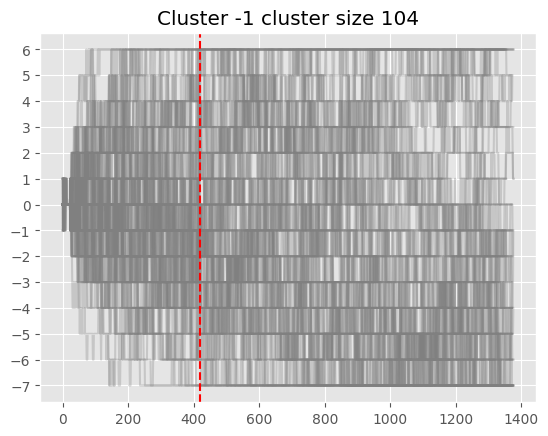

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


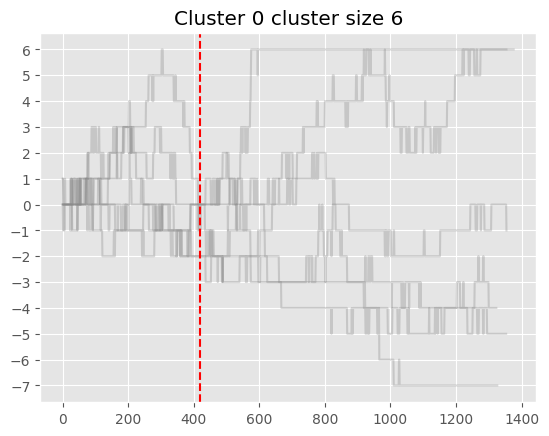

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


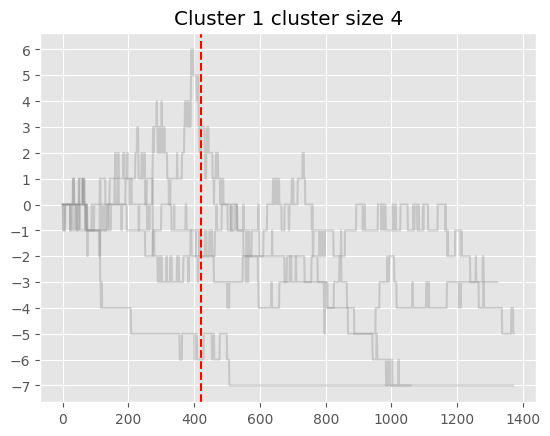

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


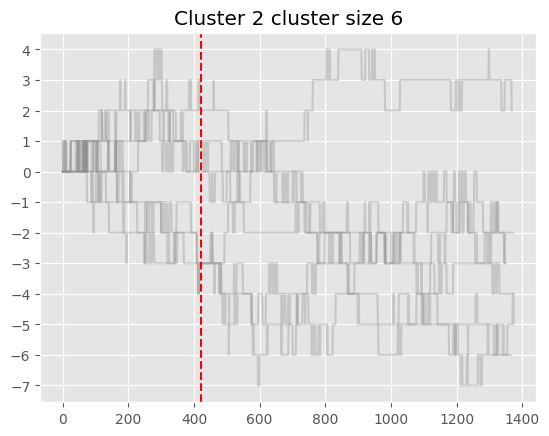

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


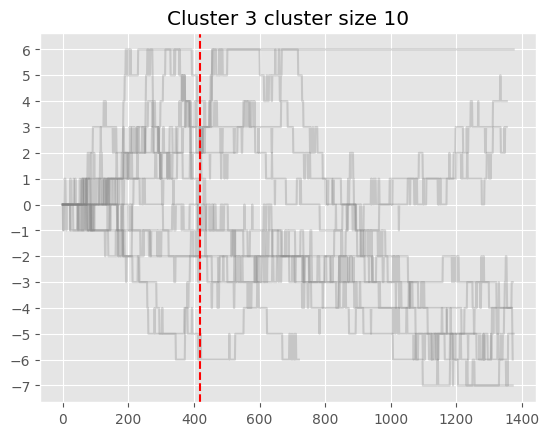

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


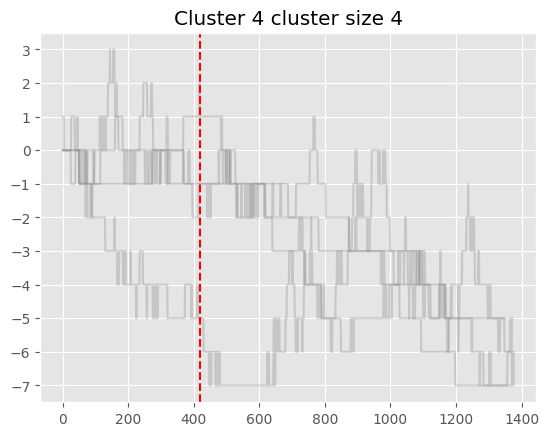

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


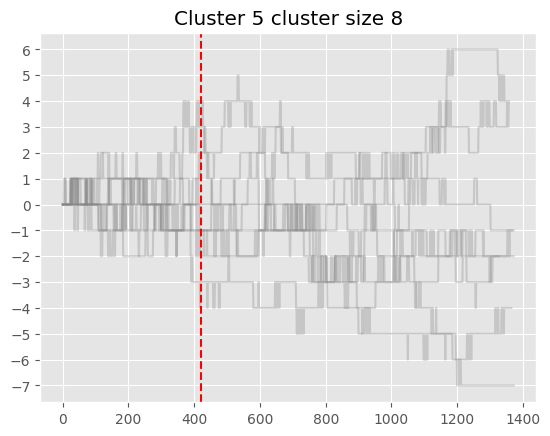

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


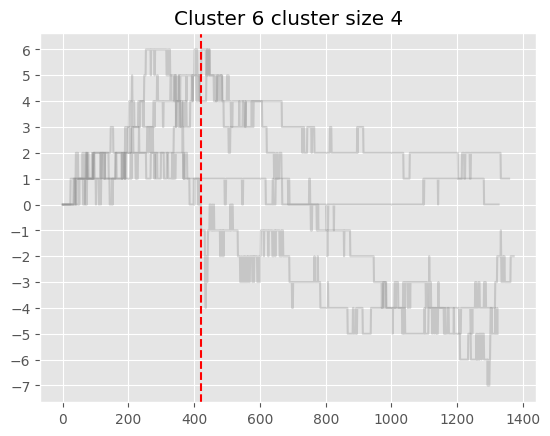

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


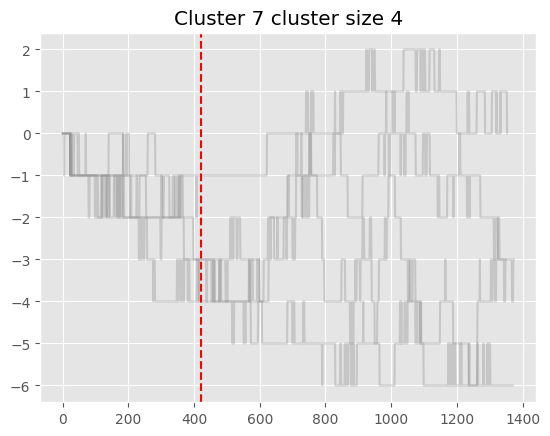

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


In [261]:
dbscan = DBSCAN(eps=0.005, min_samples=4, metric='precomputed')
labels = dbscan.fit_predict(dtw_matrix)
labels = pd.Series(labels)
LEN_GRAPH  = N_DAYS * 4 * 21

for label in labels.unique():
    weeks = X[(labels==label).values].index
    cluster_df = total_pathes_df.loc[weeks][:2*LEN_GRAPH]
    plt.title(f'Cluster {label} cluster size {cluster_df.shape[0]}')
    for diapazon_week in cluster_df.index:
        cluster_df.loc[diapazon_week].plot(alpha=0.3, color='grey')
    y_major_locator = MultipleLocator(1)  
    plt.gca().yaxis.set_major_locator(y_major_locator)
    plt.axvline(LEN_GRAPH, color='red', linestyle='--', label='analysis period')
    plt.show()
    fcluster_X =  -X[(labels==label).values].dropna(how='all', axis=1) * max_value - MIN_VALUE
    freq_levels = pd.DataFrame(index=list(range(-8, 8)), dtype=float)
    for col in cluster_X.columns:
        vc = cluster_X[col].value_counts().sort_index().astype(float)
        vc.index = vc.index.astype(int)
        freq_levels[col] = vc
    freq_levels = freq_levels.fillna(0).sum(axis=1)
    freq_levels = freq_levels[freq_levels > 0]
    print(freq_levels)
    print('-' * 45)

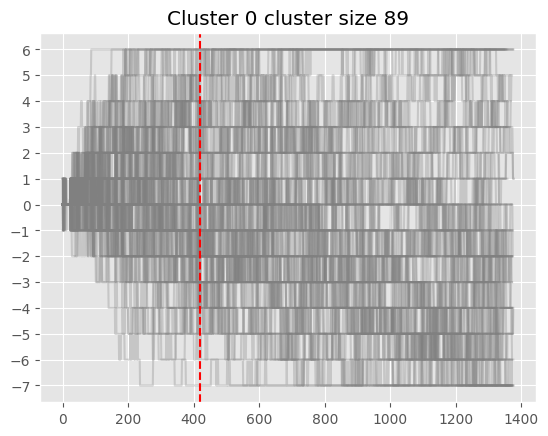

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


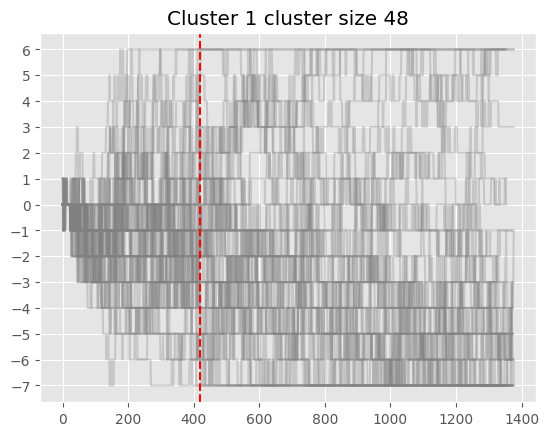

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


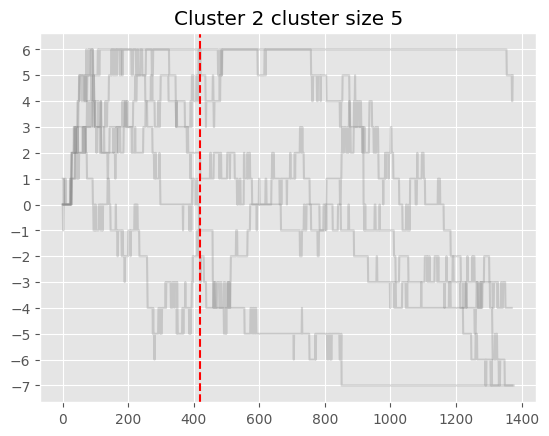

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


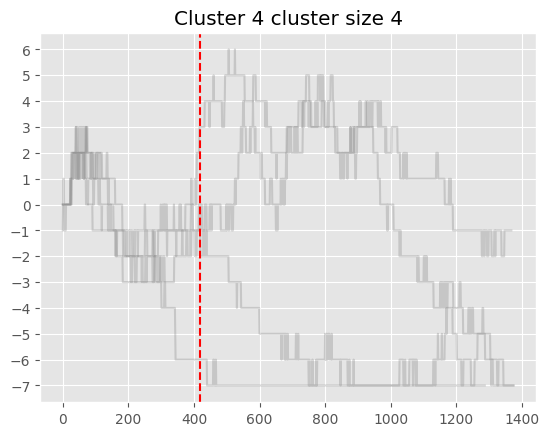

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


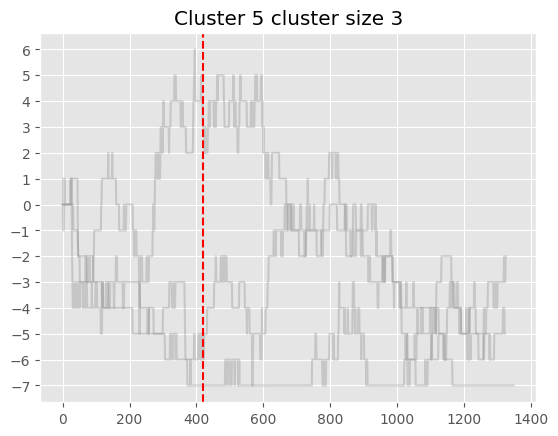

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


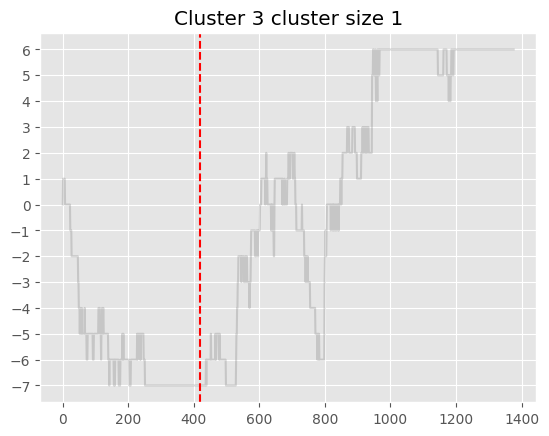

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


In [263]:
from matplotlib.ticker import MultipleLocator

agg_clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=6)
labels = agg_clustering.fit_predict(dtw_matrix)
labels = pd.Series(labels)
LEN_GRAPH  = N_DAYS * 4 * 21

for label in labels.unique():
    weeks = X[(labels==label).values].index
    cluster_df = total_pathes_df.loc[weeks][:2*LEN_GRAPH]
    plt.title(f'Cluster {label} cluster size {cluster_df.shape[0]}')
    for diapazon_week in cluster_df.index:
        cluster_df.loc[diapazon_week].plot(alpha=0.3, color='grey')
    y_major_locator = MultipleLocator(1)  
    plt.gca().yaxis.set_major_locator(y_major_locator)
    plt.axvline(LEN_GRAPH, color='red', linestyle='--', label='analysis period')
    plt.show()
    fcluster_X =  -X[(labels==label).values].dropna(how='all', axis=1) * max_value - MIN_VALUE
    freq_levels = pd.DataFrame(index=list(range(-8, 8)), dtype=float)
    for col in cluster_X.columns:
        vc = cluster_X[col].value_counts().sort_index().astype(float)
        vc.index = vc.index.astype(int)
        freq_levels[col] = vc
    freq_levels = freq_levels.fillna(0).sum(axis=1)
    freq_levels = freq_levels[freq_levels > 0]
    print(freq_levels)
    print('-' * 45)

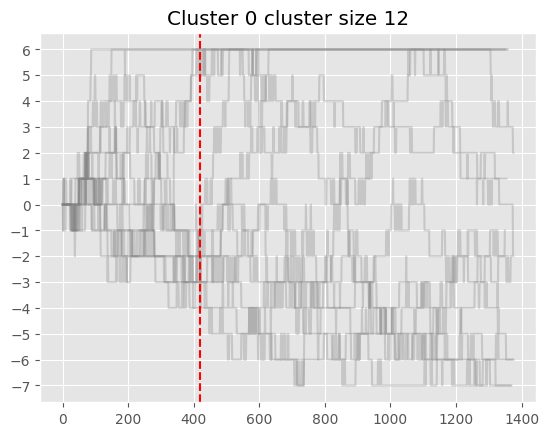

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


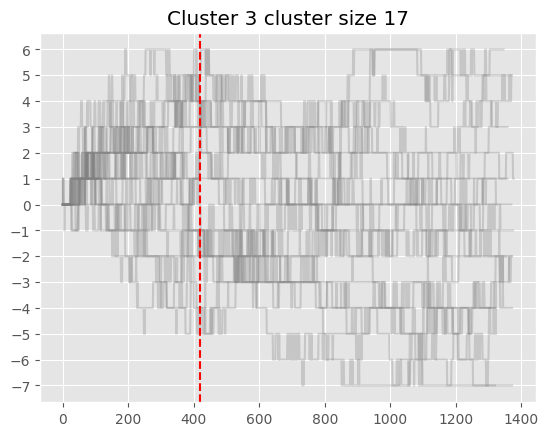

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


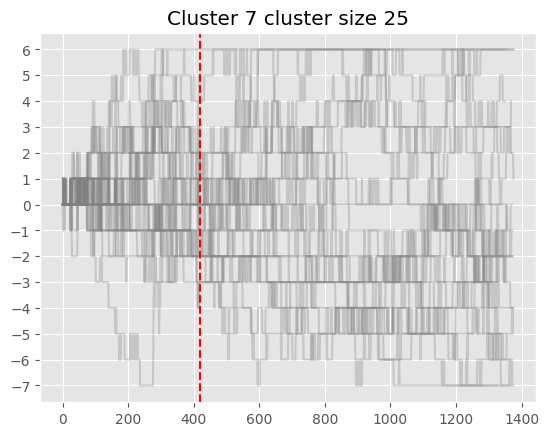

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


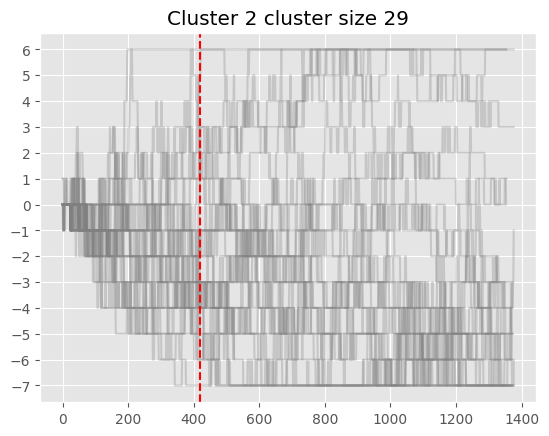

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


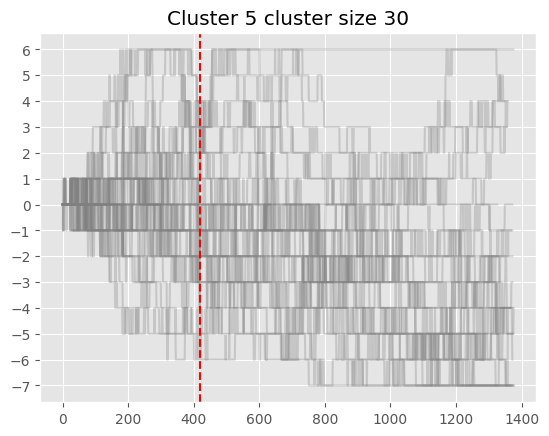

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


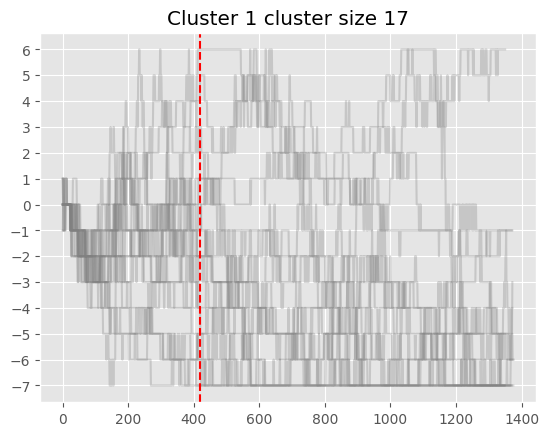

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


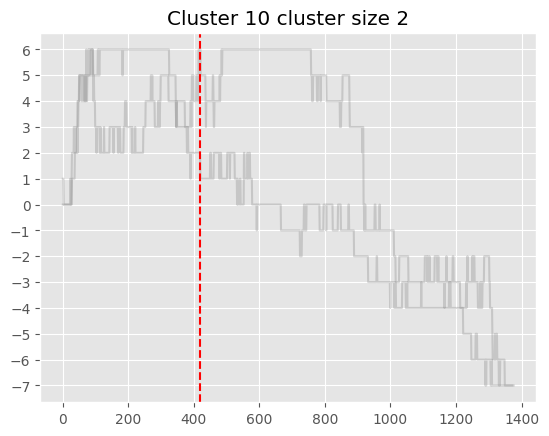

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


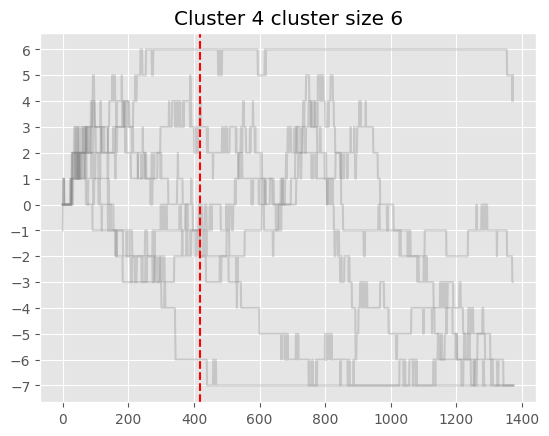

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


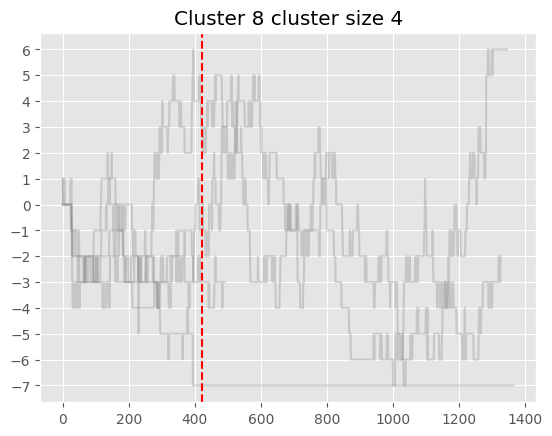

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


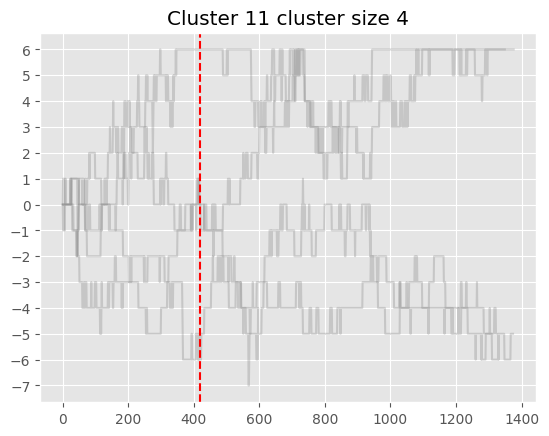

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


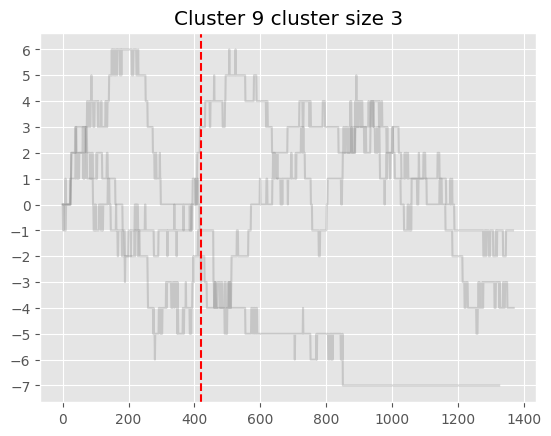

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


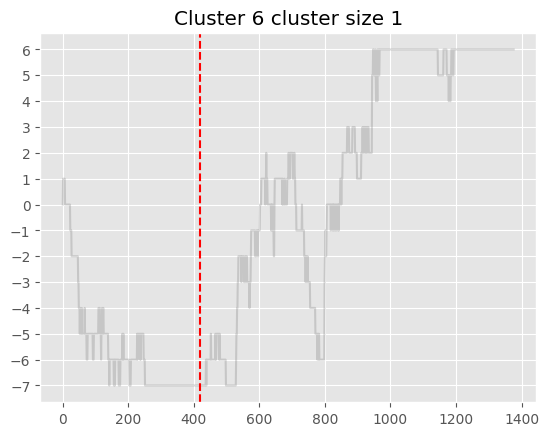

-6      2.0
-5      2.0
-4      2.0
-3     12.0
-2     34.0
-1     70.0
 0    146.0
 1    164.0
 2     62.0
 3     16.0
 4      6.0
 5      3.0
 6      2.0
dtype: float64
---------------------------------------------


In [265]:
aff_prop = AffinityPropagation()
labels = aff_prop.fit_predict(dtw_matrix)
labels = pd.Series(labels)
LEN_GRAPH  = N_DAYS * 4 * 21

for label in labels.unique():
    weeks = X[(labels==label).values].index
    cluster_df = total_pathes_df.loc[weeks][:2*LEN_GRAPH]
    plt.title(f'Cluster {label} cluster size {cluster_df.shape[0]}')
    for diapazon_week in cluster_df.index:
        cluster_df.loc[diapazon_week].plot(alpha=0.3, color='grey')
    y_major_locator = MultipleLocator(1)  
    plt.gca().yaxis.set_major_locator(y_major_locator)
    plt.axvline(LEN_GRAPH, color='red', linestyle='--', label='analysis period')
    plt.show()
    fcluster_X =  -X[(labels==label).values].dropna(how='all', axis=1) * max_value - MIN_VALUE
    freq_levels = pd.DataFrame(index=list(range(-8, 8)), dtype=float)
    for col in cluster_X.columns:
        vc = cluster_X[col].value_counts().sort_index().astype(float)
        vc.index = vc.index.astype(int)
        freq_levels[col] = vc
    freq_levels = freq_levels.fillna(0).sum(axis=1)
    freq_levels = freq_levels[freq_levels > 0]
    print(freq_levels)
    print('-' * 45)

# Clustering based on Total Paths

In [266]:
X = total_pathes_df.copy()
X = -X.iloc[:, :200] - MIN_VALUE
max_value = X.max().max()
X = X / max_value
X

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2020-10,0.5,0.571429,0.500000,0.5,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.142857,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
2020-11,0.5,0.428571,0.500000,0.5,0.500000,0.571429,0.500000,0.500000,0.500000,0.500000,...,0.142857,0.071429,0.142857,0.071429,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2020-12,0.5,0.500000,0.500000,0.5,0.500000,0.571429,0.500000,0.500000,0.500000,0.500000,...,0.571429,0.500000,0.500000,0.500000,0.500000,0.571429,0.571429,0.571429,0.571429,0.571429
2020-13,0.5,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
2020-14,0.5,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.642857,0.571429,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,0.5,0.500000,0.428571,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143,0.357143
2023-8,0.5,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
2023-9,0.5,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.428571,0.428571,...,0.357143,0.357143,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.500000
2024-1,0.5,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.metrics import pairwise_distances
def dtw_metric(a, b):
    return dtw(a[a > 0], b[b > 0], keep_internals=True).normalizedDistance
dtw_matrix = pairwise_distances(X.fillna(0), metric=dtw_metric)
print(dtw_matrix.shape)
dtw_matrix

In [ ]:
from matplotlib.ticker import MultipleLocator

agg_clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=6)
labels = agg_clustering.fit_predict(dtw_matrix)
labels = pd.Series(labels)
for label in labels.unique():
    cluster_df = X[(labels==label).values].dropna(how='all', axis=1)
    plt.title(f'Cluster {label}. Cluster size: {cluster_df.shape[0]}')
    x = pd.DataFrame()
    for col in cluster_df.index:
        vc = cluster_df.loc[col].value_counts()
        x = pd.concat([x, vc], axis=1)
    x = x.sum(axis=1) 
    x.index = -x.index * max_value - MIN_VALUE
    display(x.sort_values(ascending=False))
#     display(cluster_df)
    for diapazon_week in cluster_df.index:
        # Increase tick frequency on the y-axis


        (cluster_df.loc[diapazon_week] * max_value).plot(alpha=0.3, color='grey')
        y_major_locator = MultipleLocator(1)  # Set the interval between major ticks to 5
        plt.gca().yaxis.set_major_locator(y_major_locator)
    plt.show()

# Jaccard

In [ ]:
from sklearn.metrics import jaccard_score

min_len = min(array1.shape[0], array2.shape[0])
jaccard_similarity = jaccard_score(array1[:min_len].values, 
                                   array2[:min_len].values, average='macro')
jaccard_similarity

In [ ]:
from tqdm.notebook import tqdm
jaccard_similarity_dict = {}
for col1 in tqdm(resistance_support_table.columns):
    jaccard_similarity_dict[col1] = {}
    for col2 in resistance_support_table.drop(col1, axis=1).columns:
        array1 = resistance_support_table[col1].dropna()
        array2 = resistance_support_table[col2].dropna()
        min_len = min(array1.shape[0], array2.shape[0])
        jaccard_similarity = jaccard_score(array1[:min_len], array2[:min_len], average='macro')
        jaccard_similarity_dict[col1][col2] = jaccard_similarity

In [ ]:
pd.DataFrame(jaccard_similarity_dict)